In [ ]:
import pandas as pd
import numpy as np
import datetime
import tensorflow as tf
from tensorflow import keras
from sklearn import preprocessing
import gc
import sys
import time
import pickle
import tensorflow_datasets as tfds
import random

In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt

In [ ]:
CURRENT_PATH = './'

In [ ]:
tf.config.run_functions_eagerly(False)

In [1108]:
articles = pd.read_csv(''.join([CURRENT_PATH, 'articles.csv']), dtype=str)
customers = pd.read_csv(''.join([CURRENT_PATH, 'customers.csv']), dtype=str)

In [ ]:
df_customers_ids = pd.DataFrame({
    "customer_id": customers.customer_id,
    "customer_num": np.array(customers.index)
})

In [1109]:
df_articles_ids = pd.DataFrame({
    "article_id": articles.article_id,
    "article_num": np.array(articles.index)
})

In [ ]:
s = [
    "product_type_name",
    "product_group_name",
    "graphical_appearance_name",
    "colour_group_name",
    "perceived_colour_value_name",
    "perceived_colour_master_name",
    "section_name",
    "garment_group_name",
    "index_group_name",
    "index_name"
]
for i in s:
    articles[i] = articles[i].astype('category')

In [ ]:
def prepare_data_set(data_df):
    category_features = data_df.select_dtypes('category').columns
    #numeric_features = data_df.select_dtypes('number').columns
    df = pd.DataFrame()
    for col in category_features:
        encoder = preprocessing.LabelEncoder()
        df[col] = encoder.fit_transform(data_df[col])
    return df

In [ ]:
articles_processed = prepare_data_set(articles)

In [ ]:
[(column, customers[column].nunique()) for column in customers.columns]

In [ ]:
s = [
    "FN",
    "Active",
    "club_member_status",
    "fashion_news_frequency",
    "age"
]
for i in s:
    customers[i] = customers[i].astype('category')

In [ ]:
customers_processed = prepare_data_set(customers)

# Embedding'и для articles

### строим и обучаем модель embedding'ов

In [ ]:
def articles_embedding_data_build(articles_processed=articles_processed):
    data_in = {}
    data_out = {}

    for cat in articles_processed.columns:
        data_in['_'.join(["input", cat])] = articles_processed[cat]
        data_out['_'.join(["output", cat])] = articles_processed[cat]

    return tf.data.Dataset.from_tensor_slices((data_in, data_out))

In [ ]:
def articles_embedding_model_build():
    models = []
    inputs = []
    for cat in articles_processed.columns:
        vocab_size = articles_processed[cat].nunique()
        inpt = keras.layers.Input(shape=(1,),
                                  name='_'.join(["input", cat]))
        embed = keras.layers.Embedding(vocab_size, max([min([200, int(vocab_size * 2 / 3)]), 1]),trainable=True,
                                       embeddings_initializer=tf.initializers.random_normal)(inpt)
        embed_reshaped = keras.layers.Flatten()(embed)
        models.append(embed_reshaped)
        inputs.append(inpt)
    merge_models= tf.keras.layers.concatenate(models)
    pre_preds = keras.layers.Dense(64, name="core_embeddings")(merge_models)
    preds = []
    for cat in articles_processed.columns:
       vocab_size = articles[cat].nunique()
       preds.append(keras.layers.Dense(vocab_size, name='_'.join(["output", cat]))(pre_preds))
    return tf.keras.models.Model(inputs= inputs, outputs= preds)

In [ ]:
model_full = articles_embedding_model_build()

model_full.compile(loss={'_'.join(["output", cat]): keras.losses.SparseCategoricalCrossentropy() for cat in articles_processed.columns},
                   metrics={'_'.join(["output", cat]): ['accuracy'] for cat in articles_processed.columns},
                   optimizer='adam')

model_full.summary()

In [ ]:
articles_embedding_data_train = articles_embedding_data_build()
articles_embedding_data_train = articles_embedding_data_train.shuffle(articles_processed.shape[0] // 10)
articles_embedding_data_train = articles_embedding_data_train.batch(64)

model_full.fit(
    articles_embedding_data_train,
    validation_data=articles_embedding_data_train,
    epochs=2
)

In [ ]:
history = model_full.fit(
    articles_embedding_data_train,
    validation_data=articles_embedding_data_train,
    epochs=10
)

In [ ]:
articles_embeddings_model = keras.Model(model_full.inputs, model_full.get_layer('core_embeddings').output)

In [ ]:
articles_embeddings = articles_embeddings_model.predict(articles_embedding_data_build().batch(64))

#### протестируем и сохраним

In [ ]:
simple_model = keras.models.Sequential([
    tf.keras.layers.Dense(articles_processed.iloc[:, 2].nunique(), input_shape=(64,))
])

simple_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

simple_model.fit(articles_embeddings, articles_processed.iloc[:, 2], batch_size=64, epochs = 10)

In [ ]:
articles_embeddings_model.save(''.join([CURRENT_PATH, 'articles_embeddings_model2']))

In [ ]:
with open(''.join([CURRENT_PATH, 'articles_embeddings2.pkl']), 'wb') as outp:
    pickle.dump(articles_embeddings, outp, pickle.HIGHEST_PROTOCOL)

#### В случае предобученной модели выполняем только эти строки

In [ ]:
with open(''.join([CURRENT_PATH, 'articles_embeddings2.pkl']), 'rb') as handle:
    articles_embeddings = pickle.load(handle)

# Работаем с входным сетом

In [ ]:
transactions_train = pd.read_csv(''.join([CURRENT_PATH, 'transactions_train.csv']))

In [ ]:
n = gc.collect()
print("Number of unreachable objects collected by GC:", n)

In [ ]:
df_dates = pd.DataFrame({'t_dat': np.array(transactions_train.groupby(by=['t_dat']).count().index.tolist())})

df_dates["t_dat_date"] = np.array([datetime.datetime.strptime(date, "%Y-%m-%d").date() for date in df_dates.t_dat])
date_max = np.max(df_dates["t_dat_date"])
df_dates["t_weekn"] = np.array([int(s.days / 7) for s in date_max-df_dates["t_dat_date"]])
df_dates["t_weekn"] = np.max(df_dates["t_weekn"]) - df_dates["t_weekn"]

In [ ]:
transactions_train = transactions_train.merge(df_dates, on=['t_dat'])[['t_dat', 'customer_id', 'article_id', 't_weekn', 'price', 'sales_channel_id']]

In [ ]:
transactions_train = transactions_train.merge(df_customers_ids, on=['customer_id'])[['t_dat', 'customer_num', 'article_id', 't_weekn', 'price', 'sales_channel_id']]

In [ ]:
transactions_train = transactions_train.merge(df_articles_ids, on=['article_id'])[['t_dat', 'customer_num', 'article_num', 't_weekn', 'price', 'sales_channel_id']]

In [ ]:
transactions_train.sort_values(by = ['customer_num', 't_weekn'], inplace=True)

In [ ]:
df_weeks = pd.DataFrame({"t_weekn": np.array(df_dates["t_weekn"].unique())})
n_weeks = np.max(df_weeks.t_weekn)

In [ ]:
def cross_join_dfs(df1, df2):
    df1_temp = df1.copy()
    df2_temp = df2.copy()
    df1_temp['key'] = 0
    df2_temp['key'] = 0
    df_new = pd.merge(df1_temp, df2_temp, on = 'key', how='outer')
    df_new.pop('key')
    return df_new

In [ ]:
n = gc.collect()
print("Number of unreachable objects collected by GC:", n)

# Предсказываем число покупок по каждому артикулу

In [ ]:
def construct_articles_dataset_v1(current_week = n_weeks - 1, n_treshold = 10):
    df_dataset = pd.merge(
        df_articles_ids,
        transactions_train[transactions_train["t_weekn"] == current_week].groupby("article_num")["customer_num"].nunique(),
        how="left", left_index=True, right_index=True
    )[["article_num", "customer_num"]]
    df_dataset["target_val"] = np.array(np.nan_to_num(df_dataset["customer_num"] > n_treshold, 0), dtype=int)

    articles_history = cross_join_dfs(
        df_dataset,
        df_weeks[df_weeks["t_weekn"] < current_week]
    )[["article_num", "t_weekn"]]

    articles_history = pd.merge(
        articles_history,
        transactions_train[transactions_train["t_weekn"] < current_week].groupby(by=["article_num", 't_weekn'])["customer_num"].nunique(),
        how='left', left_on=["article_num", 't_weekn'], right_index=True
    )

    articles_history["customer_num"].fillna(0, inplace=True)

    articles_history.sort_values(by=['article_num', 't_weekn'], inplace=True)

    x = {"input_articles_history": np.reshape(np.array(articles_history["customer_num"]), (df_dataset.shape[0], articles_history.shape[0] // df_dataset.shape[0]))}
    y = {"target_val": df_dataset["target_val"]}

    return x, y

In [ ]:
def construct_articles_model_v1():
    input_layer = keras.layers.Input(shape=(None, 1), name = 'input_articles_history')
    x = keras.layers.GRU(8, activation='relu')(input_layer)
    x = keras.layers.Dense(1, activation='sigmoid', name='target_val')(x)
    return keras.models.Model(inputs = [input_layer], outputs = [x])

In [ ]:
articles_model = construct_articles_model_v1()

articles_model.summary()

In [ ]:
articles_model.compile(
    loss={"target_val": keras.losses.BinaryCrossentropy(from_logits=False)},
    optimizer=tf.keras.optimizers.Adam(learning_rate=.0001),
    metrics={"target_val": ["accuracy"]}
)

In [ ]:
articles_dataset = construct_articles_dataset_v1(n_weeks-10)

In [ ]:
SAMPLE_SIZE = articles_dataset[1]["target_val"].shape[0]
tf_dataset = tf.data.Dataset.from_tensor_slices(articles_dataset)
tf_dataset = tf_dataset.shuffle(int(SAMPLE_SIZE / 100))
test_dataset = tf_dataset.take(int(SAMPLE_SIZE * 0.2))
train_dataset = tf_dataset.skip(int(SAMPLE_SIZE * 0.2))
test_dataset = test_dataset.batch(256)
train_dataset = train_dataset.batch(256)
history = articles_model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=2
)

In [ ]:
articles_g10_probabilities = {}
for current_week in range(n_weeks-10, n_weeks+1):
    articles_dataset = construct_articles_dataset_v1(current_week)
    articles_g10_probabilities[current_week] = articles_model.predict(tf.data.Dataset.from_tensor_slices(articles_dataset).batch(256))

In [ ]:
articles_model.save(CURRENT_PATH + "articles_g10_model")

In [1148]:
for current_week in range(n_weeks-10, n_weeks):
    articles_dataset = construct_articles_dataset_v1(current_week, n_treshold=200)
    SAMPLE_SIZE = articles_dataset[1]["target_val"].shape[0]
    tf_dataset = tf.data.Dataset.from_tensor_slices(articles_dataset)
    tf_dataset = tf_dataset.shuffle(int(SAMPLE_SIZE / 100))
    test_dataset = tf_dataset.take(int(SAMPLE_SIZE * 0.2))
    train_dataset = tf_dataset.skip(int(SAMPLE_SIZE * 0.2))
    test_dataset = test_dataset.batch(256)
    train_dataset = train_dataset.batch(256)
    history = articles_model.fit(
        train_dataset,
        validation_data=test_dataset,
        epochs=2
    )

Epoch 1/2
330/330 [==============================] - 12s 36ms/step - loss: 0.0044 - accuracy: 0.9990 - val_loss: 5.9434e-04 - val_accuracy: 0.9999
Epoch 2/2
330/330 [==============================] - 11s 33ms/step - loss: 0.0021 - accuracy: 0.9996 - val_loss: 4.9567e-04 - val_accuracy: 1.0000
Epoch 1/2
330/330 [==============================] - 15s 35ms/step - loss: 0.0025 - accuracy: 0.9994 - val_loss: 7.5756e-04 - val_accuracy: 0.9999
Epoch 2/2
330/330 [==============================] - 11s 34ms/step - loss: 0.0024 - accuracy: 0.9994 - val_loss: 7.3320e-04 - val_accuracy: 0.9999


KeyboardInterrupt: 

In [ ]:
articles_g50_probabilities = {}
for current_week in range(n_weeks-10, n_weeks+2):
    articles_dataset = construct_articles_dataset_v1(current_week, n_treshold=50)
    articles_g50_probabilities[current_week] = articles_model.predict(tf.data.Dataset.from_tensor_slices(articles_dataset).batch(256))

In [1150]:
articles_g200_probabilities = {}
for current_week in range(n_weeks-10, n_weeks+2):
    articles_dataset = construct_articles_dataset_v1(current_week, n_treshold=200)
    articles_g200_probabilities[current_week] = articles_model.predict(tf.data.Dataset.from_tensor_slices(articles_dataset).batch(256))
    print("week_n =", current_week, "is done")

In [1151]:
articles_model.save(CURRENT_PATH + "articles_g200_model")

INFO:tensorflow:Assets written to: ./articles_g200_model/assets


INFO:tensorflow:Assets written to: ./articles_g200_model/assets


# Предсказываем кросс-зависимость

In [ ]:
def construct_dataset_rnn(current_week = n_weeks - 1, multiplier = 10, last_n_transactions = 50, test_data = None):
    target_dataset = pd.DataFrame()

    if test_data is not None:
        target_dataset = test_data.copy()
        target_dataset["target_val"] = 0
    else:
        transactions_target = transactions_train[transactions_train["t_weekn"] == current_week].copy()
        transactions_target["target_val"] = 1
        articles_target = transactions_target.groupby(by="article_num").count()
        articles_target = pd.DataFrame({"article_num": articles_target.index, "frequency": articles_target["customer_num"]})
        articles_target["frequency"] = articles_target["frequency"] / np.sum(articles_target["frequency"])
        articles_target.index = range(articles_target.shape[0])
        articles_target["article_target_num"] = articles_target.index
        target_dataset = pd.DataFrame({
            "customer_num": random.choices(transactions_target["customer_num"].unique(), k=transactions_target.shape[0] * multiplier),
            "article_num": random.choices(articles_target["article_num"], weights=articles_target["frequency"],
                                      k=transactions_target.shape[0] * multiplier)
        })
        target_dataset = pd.merge(target_dataset, transactions_target, on=["customer_num", "article_num"], how="left")
        target_dataset = target_dataset[target_dataset["t_dat"].isnull()][["customer_num", "article_num"]]
        target_dataset["target_val"] = 0
        target_dataset = pd.concat([target_dataset, transactions_target[["customer_num", "article_num", "target_val"]]])

    articles_target = target_dataset.groupby(by="article_num").count()
    articles_target = pd.DataFrame({"article_num": articles_target.index})
    articles_target.index = range(articles_target.shape[0])
    articles_target["article_target_num"] = articles_target.index

    customers_target = pd.DataFrame({"customer_num": target_dataset.groupby(by='customer_num').count().index})
    customers_target["customer_target_num"] = customers_target.index

    target_dataset = pd.merge(target_dataset, customers_target, on="customer_num")
    target_dataset = target_dataset.sort_values(by="customer_num")
    target_articles_embeddings = articles_embeddings[target_dataset["article_num"]]
    target_purchases = pd.merge(transactions_train[transactions_train["t_weekn"] < current_week], customers_target,
                                on="customer_num").sort_values(by=["customer_num", "t_dat"])
    target_purchases = pd.concat([
        target_purchases,
        cross_join_dfs(
            pd.DataFrame({"customer_num": customers_target["customer_num"].unique()}),
            pd.DataFrame({"t_weekn": range(-last_n_transactions, 0)})
        )])
    target_purchases["t_weekn"] = current_week - target_purchases["t_weekn"]
    target_purchases.sort_values(by=["customer_num", "t_weekn"], inplace=True)
    target_purchases["purchase_num"] = target_purchases.groupby(by=["customer_num"])["t_weekn"].cumcount() + 1
    target_purchases = target_purchases[target_purchases["purchase_num"] <= last_n_transactions].copy()
    target_purchases["purchase_num"] = last_n_transactions - target_purchases["purchase_num"]
    target_purchases["article_num"].fillna(-1, inplace=True)
    target_purchases_embeddings = np.array(
        target_purchases.pivot(index="customer_num", columns="purchase_num", values="article_num"), dtype=int)
    target_purchases_is_purchase = np.sign(target_purchases_embeddings + 1)
    target_purchases_embeddings_shape = target_purchases_embeddings.shape
    target_purchases_embeddings = np.reshape(target_purchases_embeddings,
                                             target_purchases_embeddings_shape[0] * target_purchases_embeddings_shape[1])
    target_purchases_embeddings = np.reshape(
        articles_embeddings[target_purchases_embeddings] * np.sign(target_purchases_embeddings + 1)[..., None]
        , target_purchases_embeddings_shape + (articles_embeddings.shape[1],))
    target_purchases_week_dist = np.array(
        target_purchases.pivot(index="customer_num", columns="purchase_num", values="t_weekn"), dtype=int)
    x = {
        "input_customer_num": np.array(target_dataset["customer_num"]),
        "input_customer_FN": customers_processed["FN"][target_dataset["customer_num"]],
        "input_customer_Active": customers_processed["Active"][target_dataset["customer_num"]],
        "input_customer_club_member_status": customers_processed["club_member_status"][target_dataset["customer_num"]],
        "input_customer_fashion_news_frequency": customers_processed["fashion_news_frequency"][target_dataset["customer_num"]],
        "input_customer_age": customers_processed["age"][target_dataset["customer_num"]],
        "input_article_num": np.array(target_dataset["article_num"]),
        "input_purchases_embeddings": target_purchases_embeddings[target_dataset["customer_target_num"]],
        "input_purchases_is_purchase": target_purchases_is_purchase[target_dataset["customer_target_num"]],
        "input_purchases_week_dist": target_purchases_week_dist[target_dataset["customer_target_num"]] / n_weeks,
        "input_articles_embeddings": target_articles_embeddings
    }
    y = {
        "output_target_val": np.array(target_dataset["target_val"])
    }
    return x, y

In [ ]:
def construct_dataset_plain(current_week = n_weeks - 1, multiplier = 10, test_data = None):
    target_dataset = pd.DataFrame()

    if test_data is not None:
        target_dataset = test_data.copy()
        target_dataset["target_val"] = 0
    else:
        transactions_target = transactions_train[transactions_train["t_weekn"] == current_week].copy()
        transactions_target["target_val"] = 1
        articles_target = transactions_target.groupby(by="article_num").count()
        articles_target = pd.DataFrame({"article_num": articles_target.index, "frequency": articles_target["customer_num"]})
        articles_target["frequency"] = articles_target["frequency"] / np.sum(articles_target["frequency"])
        articles_target.index = range(articles_target.shape[0])
        articles_target["article_target_num"] = articles_target.index
        target_dataset = pd.DataFrame({
            "customer_num": random.choices(transactions_target["customer_num"].unique(), k=transactions_target.shape[0] * multiplier),
            "article_num": random.choices(articles_target["article_num"], weights=articles_target["frequency"],
                                          k=transactions_target.shape[0] * multiplier)
        })
        target_dataset = pd.merge(target_dataset, transactions_target, on=["customer_num", "article_num"], how="left")
        target_dataset = target_dataset[target_dataset["t_dat"].isnull()][["customer_num", "article_num"]]
        target_dataset["target_val"] = 0
        target_dataset = pd.concat([target_dataset, transactions_target[["customer_num", "article_num", "target_val"]]])

    articles_target = target_dataset.groupby(by="article_num").count()
    articles_target = pd.DataFrame({"article_num": articles_target.index})
    articles_target.index = range(articles_target.shape[0])
    articles_target["article_target_num"] = articles_target.index

    customers_target = pd.DataFrame({"customer_num": target_dataset.groupby(by='customer_num').count().index})
    customers_target["customer_target_num"] = customers_target.index

    target_dataset = pd.merge(target_dataset, customers_target, on="customer_num")
    target_dataset = target_dataset.sort_values(by="customer_num")

    last_purchases = pd.merge(
        customers_target,
        transactions_train[transactions_train["t_weekn"] < current_week],
        how="left",
        on="customer_num")
    last_purchases = last_purchases.groupby(by="customer_num").last()
    last_purchases = pd.merge(
        last_purchases,
        articles_processed,
        how="left",
        left_on="article_num",
        right_index=True
    )
    last_purchases["logprice"] = np.log(last_purchases["price"] + 1e-07)


    x = {
        "input_customer_num": np.array(target_dataset["customer_num"], dtype=int),
        "input_article_num": np.array(target_dataset["article_num"], dtype=int),
    }
    for customer_feature in customers_processed.columns:
        x['_'.join(["input_customer", customer_feature])] = np.array(
            customers_processed[customer_feature][target_dataset["customer_num"]],
            dtype=int)
    for articles_feature in articles_processed.columns:
        x['_'.join(["input_article", articles_feature])] = np.array(
            articles_processed[articles_feature][target_dataset["article_num"]],
            dtype=int)
    for articles_feature in articles_processed.columns:
        x['_'.join(["input_purchase", articles_feature])] = np.array(
            last_purchases[articles_feature][target_dataset["customer_num"]].fillna(-1),
            dtype=int) + 1
    x["input_purchase_logprice"] = np.array(
        last_purchases["logprice"][target_dataset["customer_num"]].fillna(0),
        dtype=float)
    x["input_purchase_sales_channel_id"] = np.array(
        last_purchases["sales_channel_id"][target_dataset["customer_num"]].fillna(0),
        dtype=int)

    y = {
        "output_target_val": np.array(target_dataset["target_val"])
    }
    return x, y

In [ ]:
def construct_dataset_plain_v2(current_week = n_weeks - 1, multiplier = 10, test_data = None):
    target_dataset = pd.DataFrame()

    if test_data is not None:
        target_dataset = test_data.copy()
        target_dataset["target_val"] = 0
    else:
        transactions_target = transactions_train[transactions_train["t_weekn"] == current_week].copy()
        transactions_target["target_val"] = 1
        articles_target = transactions_target.groupby(by="article_num").count()
        articles_target = pd.DataFrame({"article_num": articles_target.index, "frequency": articles_target["customer_num"]})
        articles_target["frequency"] = articles_target["frequency"] / np.sum(articles_target["frequency"])
        articles_target.index = range(articles_target.shape[0])
        articles_target["article_target_num"] = articles_target.index
        target_dataset = pd.DataFrame({
            "customer_num": random.choices(transactions_target["customer_num"].unique(), k=transactions_target.shape[0] * multiplier),
            "article_num": random.choices(articles_target["article_num"],
                                          #weights=articles_target["frequency"],
                                          k=transactions_target.shape[0] * multiplier)
        })
        target_dataset = pd.merge(target_dataset, transactions_target, on=["customer_num", "article_num"], how="left")
        target_dataset = target_dataset[target_dataset["t_dat"].isnull()][["customer_num", "article_num"]]
        target_dataset["target_val"] = 0
        target_dataset = pd.concat([target_dataset, transactions_target[["customer_num", "article_num", "target_val"]]])

    articles_target = target_dataset.groupby(by="article_num").count()
    articles_target = pd.DataFrame({"article_num": articles_target.index})
    articles_target.index = range(articles_target.shape[0])
    articles_target["article_target_num"] = articles_target.index

    customers_target = pd.DataFrame({"customer_num": target_dataset.groupby(by='customer_num').count().index})
    customers_target["customer_target_num"] = customers_target.index

    target_dataset = pd.merge(target_dataset, customers_target, on="customer_num")
    target_dataset = target_dataset.sort_values(by="customer_num")

    last_purchases = pd.merge(
        customers_target,
        transactions_train[transactions_train["t_weekn"] < current_week],
        how="left",
        on="customer_num")
    last_purchases = last_purchases.groupby(by="customer_num").last()
    last_purchases = pd.merge(
        last_purchases,
        articles_processed,
        how="left",
        left_on="article_num",
        right_index=True
    )
    last_purchases["logprice"] = np.log(last_purchases["price"] + 1e-07)

    articles_history = transactions_train[transactions_train["t_weekn"] < current_week].groupby("article_num")[["price", "sales_channel_id"]].mean()
    articles_history["sales_channel_id"] = articles_history["sales_channel_id"] - 1
    articles_history["popularity"] = transactions_train[transactions_train["t_weekn"] < current_week].groupby("article_num")["customer_num"].nunique() / customers_processed.shape[0]
    articles_history["batchlike"] = transactions_train[transactions_train["t_weekn"] < current_week].groupby("article_num")["customer_num"].count() / transactions_train[transactions_train["t_weekn"] < current_week].groupby("article_num")["customer_num"].nunique()
    articles_history["logprice"]  = np.log(articles_history["price"])
    articles_history.drop(columns=["price"], inplace=True)
    articles_history = pd.merge(
        articles_target,
        articles_history,
        how = "left", left_on = "article_num", right_index= True
    )
    articles_history.fillna(0., inplace=True)
    articles_history.index = articles_history["article_num"]
    articles_history.drop(columns=["article_num"], inplace=True)
    articles_history.drop(columns=["article_target_num"], inplace=True)

    x = {
        "input_customer_num": np.array(target_dataset["customer_num"], dtype=int),
        "input_article_num": np.array(target_dataset["article_num"], dtype=int),
    }
    for customer_feature in customers_processed.columns:
        x['_'.join(["input_customer", customer_feature])] = np.array(
            customers_processed[customer_feature][target_dataset["customer_num"]],
            dtype=int)
    for articles_feature in articles_processed.columns:
        x['_'.join(["input_article", articles_feature])] = np.array(
            articles_processed[articles_feature][target_dataset["article_num"]],
            dtype=int)
    for articles_feature in articles_processed.columns:
        x['_'.join(["input_purchase", articles_feature])] = np.array(
            last_purchases[articles_feature][target_dataset["customer_num"]].fillna(-1),
            dtype=int) + 1
    x["input_purchase_logprice"] = np.array(
        last_purchases["logprice"][target_dataset["customer_num"]].fillna(0),
        dtype=float)
    x["input_purchase_sales_channel_id"] = np.array(
        last_purchases["sales_channel_id"][target_dataset["customer_num"]].fillna(0),
        dtype=int)
    for article_history_feature in articles_history.columns:
        x['_'.join(["input_article_history", article_history_feature])] = np.array(
            articles_history[article_history_feature][target_dataset["article_num"]],
            dtype=float
        )

    y = {
        "output_target_val": np.array(target_dataset["target_val"])
    }
    return x, y

In [ ]:
def construct_dataset_v3(current_week = n_weeks - 1, multiplier = 10, last_n_transactions = 50, test_data = None):
    target_dataset = pd.DataFrame()

    if test_data is not None:
        target_dataset = test_data.copy()
        target_dataset["target_val"] = 0
    else:
        transactions_target = transactions_train[transactions_train["t_weekn"] == current_week].copy()
        transactions_target["target_val"] = 1
        articles_target = transactions_target.groupby(by="article_num").count()
        articles_target = pd.DataFrame({"article_num": articles_target.index, "frequency": articles_target["customer_num"]})
        articles_target["frequency"] = articles_target["frequency"] / np.sum(articles_target["frequency"])
        articles_target.index = range(articles_target.shape[0])
        articles_target["article_target_num"] = articles_target.index
        target_dataset = pd.DataFrame({
            "customer_num": random.choices(transactions_target["customer_num"].unique(), k=transactions_target.shape[0] * multiplier),
            "article_num": random.choices(articles_target["article_num"],
                                          weights=articles_target["frequency"],
                                          k=transactions_target.shape[0] * multiplier)
        })
        target_dataset = pd.merge(target_dataset, transactions_target, on=["customer_num", "article_num"], how="left")
        target_dataset = target_dataset[target_dataset["t_dat"].isnull()][["customer_num", "article_num"]]
        target_dataset["target_val"] = 0
        target_dataset = pd.concat([target_dataset, transactions_target[["customer_num", "article_num", "target_val"]]])

    articles_target = target_dataset.groupby(by="article_num").count()
    articles_target = pd.DataFrame({"article_num": articles_target.index})
    articles_target.index = range(articles_target.shape[0])
    articles_target["article_target_num"] = articles_target.index

    customers_target = pd.DataFrame({"customer_num": target_dataset.groupby(by='customer_num').count().index})
    customers_target["customer_target_num"] = customers_target.index

    target_dataset = pd.merge(target_dataset, customers_target, on="customer_num")
    target_dataset = target_dataset.sort_values(by="customer_num")

    last_purchases = pd.merge(
        customers_target,
        transactions_train[transactions_train["t_weekn"] < current_week],
        on="customer_num")
    last_purchases_dummy = customers_target.copy()
    for key in [key for key in transactions_train.columns if key != "customer_num"]:
        last_purchases_dummy[key] = -1.
    last_purchases_dummy["price"] = np.mean(last_purchases["price"])
    last_purchases_dummy["sales_channel_id"] = 0
    last_purchases = pd.concat([
        last_purchases_dummy.loc[last_purchases_dummy.index.repeat(last_n_transactions)],
        last_purchases
    ])
    last_purchases = last_purchases.groupby(by="customer_num").tail(last_n_transactions)
    last_purchases["logprice"] = np.log(last_purchases["price"] + 1e-07)
    last_purchases["rand"] = np.random.rand(last_purchases.shape[0])
    last_purchases.sort_values(by=["customer_num", "t_weekn", "t_dat", "rand"], inplace=True)
    last_purchases["rank"] = last_purchases.groupby("customer_num")["article_num"].cumcount()
    article_processed_with_dummy = articles_processed.append(
        pd.DataFrame([[-1 for key in articles_processed.columns]], columns=articles_processed.columns, index=[-1])
    )

    articles_history = transactions_train[transactions_train["t_weekn"] < current_week].groupby("article_num")[["price", "sales_channel_id"]].mean()
    articles_history["sales_channel_id"] = articles_history["sales_channel_id"] - 1
    articles_history["popularity"] = transactions_train[transactions_train["t_weekn"] < current_week].groupby("article_num")["customer_num"].nunique() / customers_processed.shape[0]
    articles_history["batchlike"] = transactions_train[transactions_train["t_weekn"] < current_week].groupby("article_num")["customer_num"].count() / transactions_train[transactions_train["t_weekn"] < current_week].groupby("article_num")["customer_num"].nunique()
    articles_history["logprice"]  = np.log(articles_history["price"])
    articles_history.drop(columns=["price"], inplace=True)
    articles_history = pd.merge(
        articles_target,
        articles_history,
        how = "left", left_on = "article_num", right_index= True
    )
    articles_history.fillna(0., inplace=True)
    articles_history.index = articles_history["article_num"]
    articles_history.drop(columns=["article_num"], inplace=True)
    articles_history.drop(columns=["article_target_num"], inplace=True)

    x = {
        "input_customer_num": np.array(target_dataset["customer_num"], dtype=int),
        "input_article_num": np.array(target_dataset["article_num"], dtype=int),
    }

    for customer_feature in customers_processed.columns:
        x['_'.join(["input_customer", customer_feature])] = np.array(
            customers_processed[customer_feature][target_dataset["customer_num"]],
            dtype=int)

    for articles_feature in articles_processed.columns:
        x['_'.join(["input_article", articles_feature])] = np.array(
            articles_processed[articles_feature][target_dataset["article_num"]],
            dtype=int)

    df_purchases_articles = last_purchases.pivot(index="customer_num", columns="rank", values="article_num")
    df_purchases_articles = np.reshape(np.array(df_purchases_articles.loc[target_dataset["customer_num"]], dtype=int), (last_n_transactions * target_dataset.shape[0],))
    for articles_feature in articles_processed.columns:
        x['_'.join(["input_purchase", articles_feature])] = np.reshape(
            np.array(article_processed_with_dummy[articles_feature][df_purchases_articles], dtype=int) + 1,
            (target_dataset.shape[0], last_n_transactions)
        )
    df_purchases_logprice = last_purchases.pivot(index="customer_num", columns="rank", values="logprice")
    x["input_purchase_logprice"] = np.array(
        df_purchases_logprice.loc[target_dataset["customer_num"]],
        dtype=float)
    df_purchases_sales_channel_id = last_purchases.pivot(index="customer_num", columns="rank", values="sales_channel_id")
    x["input_purchase_sales_channel_id"] = np.array(
        df_purchases_sales_channel_id.loc[target_dataset["customer_num"]],
        dtype=int)

    for article_history_feature in articles_history.columns:
        x['_'.join(["input_article_history", article_history_feature])] = np.array(
            articles_history[article_history_feature][target_dataset["article_num"]],
            dtype=float
        )

    y = {
        "output_target_val": np.array(target_dataset["target_val"])
    }
    return x, y

In [ ]:
def construct_dataset_v4(current_week = n_weeks - 1, multiplier = 10, last_n_transactions = 50, test_data = None):
    target_dataset = pd.DataFrame()

    if test_data is not None:
        target_dataset = test_data.copy()
        target_dataset["target_val"] = 0
    else:
        transactions_target = transactions_train[transactions_train["t_weekn"] == current_week].copy()
        transactions_target["target_val"] = 1
        articles_target = transactions_target.groupby(by="article_num").count()
        articles_target = pd.DataFrame({"article_num": articles_target.index, "frequency": articles_target["customer_num"]})
        articles_target["frequency"] = articles_target["frequency"] / np.sum(articles_target["frequency"])
        articles_target.index = range(articles_target.shape[0])
        articles_target["article_target_num"] = articles_target.index
        target_dataset = pd.DataFrame({
            "customer_num": random.choices(transactions_target["customer_num"].unique(), k=transactions_target.shape[0] * multiplier),
            "article_num": random.choices(df_articles_ids["article_num"],
                                          weights=articles_g10_probabilities[current_week] / np.sum(articles_g10_probabilities[current_week]),
                                          k=transactions_target.shape[0] * multiplier)
        })
        target_dataset = pd.merge(target_dataset, transactions_target, on=["customer_num", "article_num"], how="left")
        target_dataset = target_dataset[target_dataset["t_dat"].isnull()][["customer_num", "article_num"]]
        target_dataset["target_val"] = 0
        target_dataset = pd.concat([target_dataset, transactions_target[["customer_num", "article_num", "target_val"]]])

    articles_target = target_dataset.groupby(by="article_num").count()
    articles_target = pd.DataFrame({"article_num": articles_target.index})
    articles_target.index = range(articles_target.shape[0])
    articles_target["article_target_num"] = articles_target.index

    customers_target = pd.DataFrame({"customer_num": target_dataset.groupby(by='customer_num').count().index})
    customers_target["customer_target_num"] = customers_target.index

    target_dataset = pd.merge(target_dataset, customers_target, on="customer_num")
    target_dataset = target_dataset.sort_values(by="customer_num")

    last_purchases = pd.merge(
        customers_target,
        transactions_train[transactions_train["t_weekn"] < current_week],
        on="customer_num")
    last_purchases_dummy = customers_target.copy()
    for key in [key for key in transactions_train.columns if key != "customer_num"]:
        last_purchases_dummy[key] = -1.
    last_purchases_dummy["price"] = np.mean(last_purchases["price"])
    last_purchases_dummy["sales_channel_id"] = 0
    last_purchases = pd.concat([
        last_purchases_dummy.loc[last_purchases_dummy.index.repeat(last_n_transactions)],
        last_purchases
    ])
    last_purchases = last_purchases.groupby(by="customer_num").tail(last_n_transactions)
    last_purchases["logprice"] = np.log(last_purchases["price"] + 1e-07)
    last_purchases["rand"] = np.random.rand(last_purchases.shape[0])
    last_purchases.sort_values(by=["customer_num", "t_weekn", "t_dat", "rand"], inplace=True)
    last_purchases["rank"] = last_purchases.groupby("customer_num")["article_num"].cumcount()
    article_processed_with_dummy = articles_processed.append(
        pd.DataFrame([[-1 for key in articles_processed.columns]], columns=articles_processed.columns, index=[-1])
    )

    articles_history = transactions_train[transactions_train["t_weekn"] < current_week].groupby("article_num")[["price", "sales_channel_id"]].mean()
    articles_history["sales_channel_id"] = articles_history["sales_channel_id"] - 1
    articles_history["popularity"] = transactions_train[transactions_train["t_weekn"] < current_week].groupby("article_num")["customer_num"].nunique() / customers_processed.shape[0]
    articles_history["batchlike"] = transactions_train[transactions_train["t_weekn"] < current_week].groupby("article_num")["customer_num"].count() / transactions_train[transactions_train["t_weekn"] < current_week].groupby("article_num")["customer_num"].nunique()
    articles_history["logprice"]  = np.log(articles_history["price"])
    articles_history.drop(columns=["price"], inplace=True)
    articles_history = pd.merge(
        articles_target,
        articles_history,
        how = "left", left_on = "article_num", right_index= True
    )
    articles_history.fillna(0., inplace=True)
    articles_history.index = articles_history["article_num"]
    articles_history.drop(columns=["article_num"], inplace=True)
    articles_history.drop(columns=["article_target_num"], inplace=True)

    x = {
        "input_customer_num": np.array(target_dataset["customer_num"], dtype=int),
        "input_article_num": np.array(target_dataset["article_num"], dtype=int),
    }

    for customer_feature in customers_processed.columns:
        x['_'.join(["input_customer", customer_feature])] = np.array(
            customers_processed[customer_feature][target_dataset["customer_num"]],
            dtype=int)

    for articles_feature in articles_processed.columns:
        x['_'.join(["input_article", articles_feature])] = np.array(
            articles_processed[articles_feature][target_dataset["article_num"]],
            dtype=int)

    df_purchases_articles = last_purchases.pivot(index="customer_num", columns="rank", values="article_num")
    df_purchases_articles = np.reshape(np.array(df_purchases_articles.loc[target_dataset["customer_num"]], dtype=int), (last_n_transactions * target_dataset.shape[0],))
    for articles_feature in articles_processed.columns:
        x['_'.join(["input_purchase", articles_feature])] = np.reshape(
            np.array(article_processed_with_dummy[articles_feature][df_purchases_articles], dtype=int) + 1,
            (target_dataset.shape[0], last_n_transactions)
        )
    df_purchases_logprice = last_purchases.pivot(index="customer_num", columns="rank", values="logprice")
    x["input_purchase_logprice"] = np.array(
        df_purchases_logprice.loc[target_dataset["customer_num"]],
        dtype=float)
    df_purchases_sales_channel_id = last_purchases.pivot(index="customer_num", columns="rank", values="sales_channel_id")
    x["input_purchase_sales_channel_id"] = np.array(
        df_purchases_sales_channel_id.loc[target_dataset["customer_num"]],
        dtype=int)

    for article_history_feature in articles_history.columns:
        x['_'.join(["input_article_history", article_history_feature])] = np.array(
            articles_history[article_history_feature][target_dataset["article_num"]],
            dtype=float
        )

    y = {
        "output_target_val": np.array(target_dataset["target_val"])
    }
    return x, y

In [ ]:
def construct_dataset_v5(current_week = n_weeks - 1, multiplier = 10, last_n_transactions = 50, test_data = None, max_size = -1):
    target_dataset = pd.DataFrame()

    if test_data is not None:
        target_dataset = test_data.copy()
        target_dataset["target_val"] = 0
    else:
        transactions_target = transactions_train[transactions_train["t_weekn"] == current_week].copy()
        transactions_target = pd.merge(
            transactions_target,
            df_articles_ids["article_num"][[i for i, x in enumerate(articles_g10_probabilities[current_week]>0.5) if x]],
            on="article_num"
        )
        if max_size > 0:
            transactions_target = transactions_target.sample(min(transactions_target.shape[0], int(max_size / (multiplier + 1))))
        transactions_target["target_val"] = 1
        target_dataset = pd.DataFrame({
            "customer_num": random.choices(transactions_target["customer_num"].unique(), k=transactions_target.shape[0] * multiplier),
            "article_num": random.choices(df_articles_ids["article_num"],
                                          weights=(articles_g10_probabilities[current_week] > 0.5) / np.sum(articles_g10_probabilities[current_week]),
                                          k=transactions_target.shape[0] * multiplier)
        })
        target_dataset = pd.merge(target_dataset, transactions_target, on=["customer_num", "article_num"], how="left")
        target_dataset = target_dataset[target_dataset["t_dat"].isnull()][["customer_num", "article_num"]]
        target_dataset["target_val"] = 0
        target_dataset = pd.concat([target_dataset, transactions_target[["customer_num", "article_num", "target_val"]]])

    articles_target = target_dataset.groupby(by="article_num").count()
    articles_target = pd.DataFrame({"article_num": articles_target.index})
    articles_target.index = range(articles_target.shape[0])
    articles_target["article_target_num"] = articles_target.index

    customers_target = pd.DataFrame({"customer_num": target_dataset.groupby(by='customer_num').count().index})
    customers_target["customer_target_num"] = customers_target.index

    target_dataset = pd.merge(target_dataset, customers_target, on="customer_num")
    target_dataset = target_dataset.sort_values(by="customer_num")

    last_purchases = pd.merge(
        customers_target,
        transactions_train[transactions_train["t_weekn"] < current_week],
        on="customer_num")
    last_purchases_dummy = customers_target.copy()
    for key in [key for key in transactions_train.columns if key != "customer_num"]:
        last_purchases_dummy[key] = -1.
    last_purchases_dummy["price"] = np.mean(last_purchases["price"])
    last_purchases_dummy["sales_channel_id"] = 0
    last_purchases = pd.concat([
        last_purchases_dummy.loc[last_purchases_dummy.index.repeat(last_n_transactions)],
        last_purchases
    ])
    last_purchases = last_purchases.groupby(by="customer_num").tail(last_n_transactions)
    last_purchases["logprice"] = np.log(last_purchases["price"] + 1e-07)
    last_purchases["rand"] = np.random.rand(last_purchases.shape[0])
    last_purchases.sort_values(by=["customer_num", "t_weekn", "t_dat", "rand"], inplace=True)
    last_purchases["rank"] = last_purchases.groupby("customer_num")["article_num"].cumcount()
    article_processed_with_dummy = articles_processed.append(
        pd.DataFrame([[-1 for key in articles_processed.columns]], columns=articles_processed.columns, index=[-1])
    )

    articles_history =cross_join_dfs(
        articles_target,
        df_weeks[df_weeks["t_weekn"] < current_week]
    )[["article_num", "t_weekn"]]
    articles_history = pd.merge(
        articles_history,
        transactions_train[transactions_train["t_weekn"] < current_week].groupby(by=["article_num", "t_weekn"])[["price", "sales_channel_id"]].mean(),
        how='left', left_on=["article_num", "t_weekn"], right_index=True
    )
    articles_history["logprice"]  = np.log(articles_history["price"].fillna(0.0)+1.0e-07)
    articles_history["sales_channel_id"] = (articles_history["sales_channel_id"] - 1).fillna(0.5)
    articles_history.drop(columns=["price"], inplace=True)
    # присобачиваем число кастомеров
    articles_history = pd.merge(
        articles_history,
        transactions_train[transactions_train["t_weekn"] < current_week].groupby(by=["article_num", "t_weekn"])["customer_num"].nunique(),
        how='left', left_on=["article_num", "t_weekn"], right_index=True
    )
    articles_history["customer_popularity"] = articles_history["customer_num"].fillna(0) / df_customers_ids.shape[0]
    articles_history.drop(columns=["customer_num"], inplace=True)
    articles_history = pd.merge(
        articles_history,
        transactions_train[transactions_train["t_weekn"] < current_week].groupby(by=["article_num", "t_weekn"])["customer_num"].count(),
        how='left', left_on=["article_num", "t_weekn"], right_index=True
    )
    articles_history["total_popularity"] = articles_history["customer_num"].fillna(0) / df_customers_ids.shape[0]
    articles_history.drop(columns=["customer_num"], inplace=True)

    x = {
        "input_customer_num": np.array(target_dataset["customer_num"], dtype=int),
        "input_article_num": np.array(target_dataset["article_num"], dtype=int),
    }

    for customer_feature in customers_processed.columns:
        x['_'.join(["input_customer", customer_feature])] = np.array(
            customers_processed[customer_feature][target_dataset["customer_num"]],
            dtype=int)

    for articles_feature in articles_processed.columns:
        x['_'.join(["input_article", articles_feature])] = np.array(
            articles_processed[articles_feature][target_dataset["article_num"]],
            dtype=int)

    df_purchases_articles = last_purchases.pivot(index="customer_num", columns="rank", values="article_num")
    df_purchases_articles = np.reshape(np.array(df_purchases_articles.loc[target_dataset["customer_num"]], dtype=int), (last_n_transactions * target_dataset.shape[0],))
    for articles_feature in articles_processed.columns:
        x['_'.join(["input_purchase", articles_feature])] = np.reshape(
            np.array(article_processed_with_dummy[articles_feature][df_purchases_articles], dtype=int) + 1,
            (target_dataset.shape[0], last_n_transactions)
        )
    df_purchases_logprice = last_purchases.pivot(index="customer_num", columns="rank", values="logprice")
    x["input_purchase_logprice"] = np.array(
        df_purchases_logprice.loc[target_dataset["customer_num"]],
        dtype=float)
    df_purchases_sales_channel_id = last_purchases.pivot(index="customer_num", columns="rank", values="sales_channel_id")
    x["input_purchase_sales_channel_id"] = np.array(
        df_purchases_sales_channel_id.loc[target_dataset["customer_num"]],
        dtype=int)

    for article_history_feature in [key for key in articles_history.columns if key not in ["customer_num", "article_num"]]:
        df_articles_pivot = articles_history.pivot(index="article_num", columns="t_weekn", values=article_history_feature)
        x['_'.join(["input_article_history", article_history_feature])] = np.array(
            df_articles_pivot.loc[target_dataset["article_num"]],
            dtype=float
        )

    y = {
        "output_target_val": np.array(target_dataset["target_val"])
    }
    return x, y

In [994]:
def construct_dataset_v7(current_week = n_weeks - 1, multiplier = 10, last_n_transactions = 50, test_data = None, max_size = -1,articles_probabilities = articles_g10_probabilities):
    target_dataset = pd.DataFrame()

    if test_data is not None:
        target_dataset = test_data.copy()
        target_dataset["target_val"] = 0
    else:
        transactions_target = transactions_train[transactions_train["t_weekn"] == current_week].copy()
        transactions_target = pd.merge(
            transactions_target,
            df_articles_ids["article_num"][[i for i, x in enumerate(articles_probabilities[current_week]>0.5) if x]],
            on="article_num"
        )
        if max_size > 0:
            transactions_target = transactions_target.sample(min(transactions_target.shape[0], int(max_size / (multiplier + 1))))
        transactions_target["target_val"] = 1
        target_dataset = pd.DataFrame({
            "customer_num": random.choices(transactions_target["customer_num"].unique(), k=transactions_target.shape[0] * multiplier),
            "article_num": random.choices(df_articles_ids["article_num"],
                                          weights=(articles_probabilities[current_week] > 0.5) / np.sum(articles_probabilities[current_week]),
                                          k=transactions_target.shape[0] * multiplier)
        })
        target_dataset = pd.merge(target_dataset, transactions_target, on=["customer_num", "article_num"], how="left")
        target_dataset = target_dataset[target_dataset["t_dat"].isnull()][["customer_num", "article_num"]]
        target_dataset["target_val"] = 0
        target_dataset = pd.concat([target_dataset, transactions_target[["customer_num", "article_num", "target_val"]]])

    articles_target = target_dataset.groupby(by="article_num").count()
    articles_target = pd.DataFrame({"article_num": articles_target.index})
    articles_target.index = range(articles_target.shape[0])
    articles_target["article_target_num"] = articles_target.index

    customers_target = pd.DataFrame({"customer_num": target_dataset.groupby(by='customer_num').count().index})
    customers_target["customer_target_num"] = customers_target.index

    target_dataset = pd.merge(target_dataset, customers_target, on="customer_num")
    target_dataset = target_dataset.sort_values(by="customer_num")

    last_purchases = pd.merge(
        customers_target,
        transactions_train[transactions_train["t_weekn"] < current_week],
        on="customer_num")
    last_purchases_dummy = customers_target.copy()
    for key in [key for key in transactions_train.columns if key != "customer_num"]:
        last_purchases_dummy[key] = -1.
    last_purchases_dummy["price"] = np.mean(last_purchases["price"])
    last_purchases_dummy["sales_channel_id"] = 0
    last_purchases = pd.concat([
        last_purchases_dummy.loc[last_purchases_dummy.index.repeat(last_n_transactions)],
        last_purchases
    ])
    last_purchases = last_purchases.groupby(by="customer_num").tail(last_n_transactions)
    last_purchases["logprice"] = np.log(last_purchases["price"] + 1e-07)
    last_purchases["rand"] = np.random.rand(last_purchases.shape[0])
    last_purchases.sort_values(by=["customer_num", "t_weekn", "t_dat", "rand"], inplace=True)
    last_purchases["rank"] = last_purchases.groupby("customer_num")["article_num"].cumcount()
    article_processed_with_dummy = articles_processed.append(
        pd.DataFrame([[-1 for key in articles_processed.columns]], columns=articles_processed.columns, index=[-1])
    )

    articles_history =cross_join_dfs(
        articles_target,
        df_weeks[df_weeks["t_weekn"] < current_week]
    )[["article_num", "t_weekn"]]
    articles_history = pd.merge(
        articles_history,
        transactions_train[transactions_train["t_weekn"] < current_week].groupby(by=["article_num", "t_weekn"])[["price", "sales_channel_id"]].mean(),
        how='left', left_on=["article_num", "t_weekn"], right_index=True
    )
    articles_history["logprice"]  = np.log(articles_history["price"].fillna(0.0)+1.0e-07)
    articles_history["sales_channel_id"] = (articles_history["sales_channel_id"] - 1).fillna(0.5)
    articles_history.drop(columns=["price"], inplace=True)
    # присобачиваем число кастомеров
    articles_history = pd.merge(
        articles_history,
        transactions_train[transactions_train["t_weekn"] < current_week].groupby(by=["article_num", "t_weekn"])["customer_num"].nunique(),
        how='left', left_on=["article_num", "t_weekn"], right_index=True
    )
    articles_history["customer_popularity"] = articles_history["customer_num"].fillna(0) / 400
    articles_history.drop(columns=["customer_num"], inplace=True)
    articles_history = pd.merge(
        articles_history,
        transactions_train[transactions_train["t_weekn"] < current_week].groupby(by=["article_num", "t_weekn"])["customer_num"].count(),
        how='left', left_on=["article_num", "t_weekn"], right_index=True
    )
    articles_history["total_popularity"] = articles_history["customer_num"].fillna(0) / 400
    articles_history.drop(columns=["customer_num"], inplace=True)

    x = {
        "input_customer_num": np.array(target_dataset["customer_num"], dtype=int),
        "input_article_num": np.array(target_dataset["article_num"], dtype=int),
    }

    for customer_feature in customers_processed.columns:
        x['_'.join(["input_customer", customer_feature])] = np.array(
            customers_processed[customer_feature][target_dataset["customer_num"]],
            dtype=int)

    for articles_feature in articles_processed.columns:
        x['_'.join(["input_article", articles_feature])] = np.array(
            articles_processed[articles_feature][target_dataset["article_num"]],
            dtype=int)

    df_purchases_articles = last_purchases.pivot(index="customer_num", columns="rank", values="article_num")
    df_purchases_articles = np.reshape(np.array(df_purchases_articles.loc[target_dataset["customer_num"]], dtype=int), (last_n_transactions * target_dataset.shape[0],))

    for articles_feature in articles_processed.columns:
        x['_'.join(["input_purchase", articles_feature])] = np.reshape(
            np.array(article_processed_with_dummy[articles_feature][df_purchases_articles], dtype=int) + 1,
            (target_dataset.shape[0], last_n_transactions)
        )
    df_purchases_logprice = last_purchases.pivot(index="customer_num", columns="rank", values="logprice")
    x["input_purchase_logprice"] = np.array(
        df_purchases_logprice.loc[target_dataset["customer_num"]],
        dtype=float)
    df_purchases_sales_channel_id = last_purchases.pivot(index="customer_num", columns="rank", values="sales_channel_id")
    x["input_purchase_sales_channel_id"] = np.array(
        df_purchases_sales_channel_id.loc[target_dataset["customer_num"]],
        dtype=int)

    for article_history_feature in [key for key in articles_history.columns if key not in ["customer_num", "article_num"]]:
        df_articles_pivot = articles_history.pivot(index="article_num", columns="t_weekn", values=article_history_feature)
        x['_'.join(["input_article_history", article_history_feature])] = np.array(
            df_articles_pivot.loc[target_dataset["article_num"]],
            dtype=float
        )[:, -54:]

    y = {
        "output_target_val": np.array(target_dataset["target_val"])
    }
    return x, y

In [1022]:
dataset = construct_dataset_v7(current_week=n_weeks, multiplier=4, max_size = 100000, articles_probabilities=articles_g50_probabilities)

In [1023]:
df_temp = pd.DataFrame({
    "article_num": dataset[0]["input_article_num"],
    "predict": model.predict(tf.data.Dataset.from_tensor_slices(dataset).batch(256))[:, 0],
    "y": dataset[1]["output_target_val"]
})

df_temp = pd.merge(
    df_temp,
    transactions_train[transactions_train["t_weekn"] == n_weeks - 1].groupby("article_num")["customer_num"].nunique(),
    how="left", on="article_num"
)

df_temp["customer_num"].fillna(0, inplace=True)

/Users/vvborzov/opt/anaconda3/lib/python3.9/site-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['input_customer_num', 'input_article_num', 'input_article_history_t_weekn'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


gini our model = 0.43304907975844453
gini naive model = 0.2398229327453143


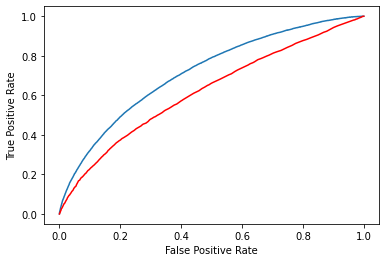

In [1024]:
fpr, tpr, _ = metrics.roc_curve(
    df_temp["y"]
    ,  df_temp["predict"]
)

print("gini our model =", metrics.auc(fpr, tpr)*2 - 1)

fpr2, tpr2, _ = metrics.roc_curve(
    df_temp["y"]
    ,  df_temp["customer_num"]
)

print("gini naive model =", metrics.auc(fpr2, tpr2)*2 - 1)
#create ROC curve
plt.plot(fpr,tpr)
plt.plot(fpr2,tpr2, "r")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [1025]:
del fpr, tpr, dataset, df_temp

In [1026]:
gc.collect()

106641

#### конструируем модель

In [ ]:
def customer_embedding_model_build_rnn():
    input_layer1 = keras.layers.Input(shape=(None, 64), name="input_purchases_embeddings")
    input_layer2 = keras.layers.Input(shape=(None, 1), name="input_purchases_is_purchase")
    input_layer3 = keras.layers.Input(shape=(None, 1), name="input_purchases_week_dist")
    input_layer4 = keras.layers.Input(shape=(64,), name="input_articles_embeddings")

    input_layers = [input_layer1, input_layer2, input_layer3, input_layer4]

    customer_embedding_layers = []
    for key in customers_processed.keys():
        vocab_size = customers_processed[key].nunique()
        input_layer = keras.layers.Input(shape=(1,), name='_'.join(["input_customer", key]))
        input_layers.append(input_layer)
        embedding_layer = keras.layers.Embedding(
            vocab_size, int(vocab_size * 2 / 3),
            trainable=True,
            embeddings_initializer=tf.initializers.random_normal)(input_layer)
        embedding_layer = keras.layers.Flatten()(embedding_layer)
        customer_embedding_layers.append(embedding_layer)
    embedding_layer_concatenated = tf.keras.layers.concatenate(customer_embedding_layers)

    x = tf.keras.layers.concatenate([input_layer1, input_layer2, input_layer3])
    x = keras.layers.GRU(128, return_sequences=False, name = "gru_embedding")(x)

    x = tf.keras.layers.concatenate([
        x,
        embedding_layer_concatenated,
        input_layer4
    ])

    x = tf.keras.layers.Dense(32, activation = 'relu')(x)
    x = tf.keras.layers.Dense(32, activation = 'tanh')(x)

    outputs = [tf.keras.layers.Dense(1, name="output_target_val")(x)]

    return keras.models.Model(inputs = input_layers, outputs = outputs)

In [ ]:
def customer_embedding_model_build_plain():
    input_layers = list()

    customer_encode_layers = list()
    for customer_feature in customers_processed.columns:
        vocab_size = customers_processed[customer_feature].nunique()
        customer_input_layer = keras.layers.Input(shape=(1,), name='_'.join(["input_customer", customer_feature]))
        customer_encode_layer = tf.keras.layers.CategoryEncoding(num_tokens=vocab_size, output_mode="one_hot")(customer_input_layer)
        input_layers.append(customer_input_layer)
        customer_encode_layers.append(customer_encode_layer)

    customer_encode_layer_concatenated = tf.keras.layers.concatenate(customer_encode_layers)
    customer_embedding_layer = tf.keras.layers.Dense(64, activation = 'relu')(customer_encode_layer_concatenated)

    articles_encode_layers = list()
    for article_feature in articles_processed.columns:
        vocab_size = articles_processed[article_feature].nunique()
        article_input_layer = keras.layers.Input(shape=(1,), name='_'.join(["input_article", article_feature]))
        article_encode_layer = tf.keras.layers.CategoryEncoding(num_tokens=vocab_size, output_mode="one_hot")(article_input_layer)
        input_layers.append(article_input_layer)
        articles_encode_layers.append(article_encode_layer)

    article_encode_layer_concatenated = tf.keras.layers.concatenate(articles_encode_layers)
    article_embedding_layer = tf.keras.layers.Dense(128, activation = 'relu')(article_encode_layer_concatenated)
    article_embedding_layer = tf.keras.layers.Dense(64, activation = 'relu')(article_embedding_layer)

    customer_purchases_layers = list()
    for article_feature in articles_processed.columns:
        vocab_size = articles_processed[article_feature].nunique()
        purchase_input_layer = keras.layers.Input(shape=(1,), name='_'.join(["input_purchase", article_feature]))
        purchase_encode_layer = tf.keras.layers.CategoryEncoding(num_tokens=vocab_size+1, output_mode="one_hot")(purchase_input_layer)
        input_layers.append(purchase_input_layer)
        customer_purchases_layers.append(purchase_encode_layer)
    purchase_input_layer = keras.layers.Input(shape=(1,), name="input_purchase_logprice")
    input_layers.append(purchase_input_layer)
    customer_purchases_layers.append(purchase_input_layer)
    purchase_input_layer = keras.layers.Input(shape=(1,), name="input_purchase_sales_channel_id")
    purchase_encode_layer = tf.keras.layers.CategoryEncoding(num_tokens=3, output_mode="one_hot")(purchase_input_layer)
    input_layers.append(purchase_input_layer)
    customer_purchases_layers.append(purchase_encode_layer)

    purchase_encode_layer_concatenated = tf.keras.layers.concatenate(customer_purchases_layers)
    purchase_embedding_layer = tf.keras.layers.Dense(128, activation = 'relu')(purchase_encode_layer_concatenated)
    purchase_embedding_layer = tf.keras.layers.Dense(64, activation = 'relu')(purchase_embedding_layer)

    x = tf.keras.layers.concatenate([
        customer_embedding_layer,
        article_embedding_layer,
        purchase_embedding_layer
    ])

    x = tf.keras.layers.Dense(64, activation = 'relu')(x)
    x = tf.keras.layers.Dense(32, activation = 'relu')(x)
    x = tf.keras.layers.Dense(16, activation = 'relu')(x)

    outputs = [tf.keras.layers.Dense(1, name="output_target_val")(x)]

    return keras.models.Model(inputs = input_layers, outputs = outputs)

In [ ]:
def customer_embedding_model_build_plain_v2():
    input_layers = list()

    customer_encode_layers = list()
    for customer_feature in customers_processed.columns:
        vocab_size = customers_processed[customer_feature].nunique()
        customer_input_layer = keras.layers.Input(shape=(1,), name='_'.join(["input_customer", customer_feature]))
        customer_encode_layer = tf.keras.layers.CategoryEncoding(num_tokens=vocab_size, output_mode="one_hot")(customer_input_layer)
        input_layers.append(customer_input_layer)
        customer_encode_layers.append(customer_encode_layer)

    customer_encode_layer_concatenated = tf.keras.layers.concatenate(customer_encode_layers)
    customer_embedding_layer = tf.keras.layers.Dense(32, activation = 'relu', name = 'dense_customer_l0')(customer_encode_layer_concatenated)

    articles_encode_layers = list()
    for article_feature in articles_processed.columns:
        vocab_size = articles_processed[article_feature].nunique()
        article_input_layer = keras.layers.Input(shape=(1,), name='_'.join(["input_article", article_feature]))
        article_encode_layer = tf.keras.layers.CategoryEncoding(num_tokens=vocab_size, output_mode="one_hot")(article_input_layer)
        input_layers.append(article_input_layer)
        articles_encode_layers.append(article_encode_layer)

    article_encode_layer_concatenated = tf.keras.layers.concatenate(articles_encode_layers)
    article_embedding_layer = tf.keras.layers.Dense(64, activation = 'relu', name = 'dense_article_l0')(article_encode_layer_concatenated)
    article_embedding_layer = tf.keras.layers.Dense(64, activation = 'relu', name = 'dense_article_l1')(article_embedding_layer)

    customer_purchases_layers = list()
    for article_feature in articles_processed.columns:
        vocab_size = articles_processed[article_feature].nunique()
        purchase_input_layer = keras.layers.Input(shape=(1,), name='_'.join(["input_purchase", article_feature]))
        purchase_encode_layer = tf.keras.layers.CategoryEncoding(num_tokens=vocab_size+1, output_mode="one_hot")(purchase_input_layer)
        input_layers.append(purchase_input_layer)
        customer_purchases_layers.append(purchase_encode_layer)
    purchase_input_layer = keras.layers.Input(shape=(1,), name="input_purchase_logprice")
    input_layers.append(purchase_input_layer)
    customer_purchases_layers.append(purchase_input_layer)
    purchase_input_layer = keras.layers.Input(shape=(1,), name="input_purchase_sales_channel_id")
    purchase_encode_layer = tf.keras.layers.CategoryEncoding(num_tokens=3, output_mode="one_hot")(purchase_input_layer)
    input_layers.append(purchase_input_layer)
    customer_purchases_layers.append(purchase_encode_layer)

    purchase_encode_layer_concatenated = tf.keras.layers.concatenate(customer_purchases_layers)
    purchase_embedding_layer = tf.keras.layers.Dense(64, activation = 'relu', name = 'dense_purchase_history_l0')(purchase_encode_layer_concatenated)
    purchase_embedding_layer = tf.keras.layers.Dense(64, activation = 'relu', name = 'dense_purchase_history_l1')(purchase_embedding_layer)

    articles_history_encode_layers = list()
    for article_history_feature in ["sales_channel_id", "popularity", "batchlike", "logprice"]:
        article_history_input_layer = keras.layers.Input(shape=(1,), name='_'.join(["input_article_history", article_history_feature]))
        input_layers.append(article_history_input_layer)
        articles_history_encode_layers.append(article_history_input_layer)

    articles_history_concatenated = tf.keras.layers.concatenate(articles_history_encode_layers)
    articles_history_embedding_layer = tf.keras.layers.Dense(8, activation = 'relu', name = 'dense_article_history_l0')(articles_history_concatenated)

    x = tf.keras.layers.concatenate([
        customer_embedding_layer,
        article_embedding_layer,
        purchase_embedding_layer,
        articles_history_embedding_layer
    ])

    x = tf.keras.layers.Dense(64, activation = 'relu', name = 'dense_t3')(x)
    x = tf.keras.layers.Dense(32, activation = 'relu', name = 'dense_t2')(x)
    x = tf.keras.layers.Dense(16, activation = 'relu', name = "dense_t1")(x)

    outputs = [tf.keras.layers.Dense(1, name="output_target_val")(x)]

    return keras.models.Model(inputs = input_layers, outputs = outputs)

In [ ]:
def customer_embedding_model_build_v3():
    input_layers = list()

    customer_encode_layers = list()
    for customer_feature in customers_processed.columns:
        vocab_size = customers_processed[customer_feature].nunique()
        customer_input_layer = keras.layers.Input(shape=(1,), name='_'.join(["input_customer", customer_feature]))
        customer_encode_layer = tf.keras.layers.CategoryEncoding(num_tokens=vocab_size, output_mode="one_hot")(customer_input_layer)
        input_layers.append(customer_input_layer)
        customer_encode_layers.append(customer_encode_layer)

    customer_encode_layer_concatenated = tf.keras.layers.concatenate(customer_encode_layers)
    customer_embedding_layer = tf.keras.layers.Dense(32, activation = 'relu', name = 'dense_customer_l0')(customer_encode_layer_concatenated)

    articles_encode_layers = list()
    for article_feature in articles_processed.columns:
        vocab_size = articles_processed[article_feature].nunique()
        article_input_layer = keras.layers.Input(shape=(1,), name='_'.join(["input_article", article_feature]))
        article_encode_layer = tf.keras.layers.CategoryEncoding(num_tokens=vocab_size, output_mode="one_hot")(article_input_layer)
        input_layers.append(article_input_layer)
        articles_encode_layers.append(article_encode_layer)

    article_encode_layer_concatenated = tf.keras.layers.concatenate(articles_encode_layers)
    article_embedding_layer = tf.keras.layers.Dense(64, activation = 'relu', name = 'dense_article_l0')(article_encode_layer_concatenated)
    article_embedding_layer = tf.keras.layers.Dense(64, activation = 'relu', name = 'dense_article_l1')(article_embedding_layer)

    customer_purchases_layers = list()
    for article_feature in articles_processed.columns:
        vocab_size = articles_processed[article_feature].nunique()+1
        purchase_input_layer = keras.layers.Input(shape=(None, ), name='_'.join(["input_purchase", article_feature]))
        purchase_encode_layer = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=int(vocab_size*2.0/3))(purchase_input_layer)
        input_layers.append(purchase_input_layer)
        customer_purchases_layers.append(purchase_encode_layer)
    purchase_input_layer = keras.layers.Input(shape=(None, 1), name="input_purchase_logprice")
    input_layers.append(purchase_input_layer)
    customer_purchases_layers.append(purchase_input_layer)
    purchase_input_layer = keras.layers.Input(shape=(None, ), name="input_purchase_sales_channel_id")
    purchase_encode_layer = tf.keras.layers.Embedding(input_dim=3, output_dim=2)(purchase_input_layer)
    input_layers.append(purchase_input_layer)
    customer_purchases_layers.append(purchase_encode_layer)

    purchase_encode_layer_concatenated = tf.keras.layers.concatenate(customer_purchases_layers)
    purchase_embedding_layer = tf.keras.layers.GRU(64, activation = 'relu', name = 'GRU_purchase_history_l0')(purchase_encode_layer_concatenated)

    articles_history_encode_layers = list()
    for article_history_feature in ["sales_channel_id", "popularity", "batchlike", "logprice"]:
        article_history_input_layer = keras.layers.Input(shape=(1,), name='_'.join(["input_article_history", article_history_feature]))
        input_layers.append(article_history_input_layer)
        articles_history_encode_layers.append(article_history_input_layer)

    articles_history_concatenated = tf.keras.layers.concatenate(articles_history_encode_layers)
    articles_history_embedding_layer = tf.keras.layers.Dense(8, activation = 'relu', name = 'dense_article_history_l0')(articles_history_concatenated)

    x = tf.keras.layers.concatenate([
        customer_embedding_layer,
        article_embedding_layer,
        purchase_embedding_layer,
        articles_history_embedding_layer
    ])

    x = tf.keras.layers.Dense(64, activation = 'relu', name = 'dense_t3')(x)
    x = tf.keras.layers.Dense(32, activation = 'relu', name = 'dense_t2')(x)
    x = tf.keras.layers.Dense(16, activation = 'relu', name = "dense_t1")(x)

    outputs = [tf.keras.layers.Dense(1, name="output_target_val")(x)]

    return keras.models.Model(inputs = input_layers, outputs = outputs)

In [ ]:
def customer_embedding_model_build_v5():
    input_layers = list()

    customer_encode_layers = list()
    for customer_feature in customers_processed.columns:
        vocab_size = customers_processed[customer_feature].nunique()
        customer_input_layer = keras.layers.Input(shape=(1,), name='_'.join(["input_customer", customer_feature]))
        customer_encode_layer = tf.keras.layers.CategoryEncoding(num_tokens=vocab_size, output_mode="one_hot")(customer_input_layer)
        input_layers.append(customer_input_layer)
        customer_encode_layers.append(customer_encode_layer)

    customer_encode_layer_concatenated = tf.keras.layers.concatenate(customer_encode_layers)
    customer_embedding_layer = tf.keras.layers.Dense(32, activation = 'relu', name = 'dense_customer_l0')(customer_encode_layer_concatenated)

    articles_encode_layers = list()
    for article_feature in articles_processed.columns:
        vocab_size = articles_processed[article_feature].nunique()
        article_input_layer = keras.layers.Input(shape=(1,), name='_'.join(["input_article", article_feature]))
        article_encode_layer = tf.keras.layers.CategoryEncoding(num_tokens=vocab_size, output_mode="one_hot")(article_input_layer)
        input_layers.append(article_input_layer)
        articles_encode_layers.append(article_encode_layer)

    article_encode_layer_concatenated = tf.keras.layers.concatenate(articles_encode_layers)
    article_embedding_layer = tf.keras.layers.Dense(64, activation = 'relu', name = 'dense_article_l0')(article_encode_layer_concatenated)
    article_embedding_layer = tf.keras.layers.Dense(64, activation = 'relu', name = 'dense_article_l1')(article_embedding_layer)

    customer_purchases_layers = list()
    for article_feature in articles_processed.columns:
        vocab_size = articles_processed[article_feature].nunique()+1
        purchase_input_layer = keras.layers.Input(shape=(None, ), name='_'.join(["input_purchase", article_feature]))
        purchase_encode_layer = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=int(vocab_size*2.0/3))(purchase_input_layer)
        input_layers.append(purchase_input_layer)
        customer_purchases_layers.append(purchase_encode_layer)
    purchase_input_layer = keras.layers.Input(shape=(None, 1), name="input_purchase_logprice")
    input_layers.append(purchase_input_layer)
    customer_purchases_layers.append(purchase_input_layer)
    purchase_input_layer = keras.layers.Input(shape=(None, ), name="input_purchase_sales_channel_id")
    purchase_encode_layer = tf.keras.layers.Embedding(input_dim=3, output_dim=2)(purchase_input_layer)
    input_layers.append(purchase_input_layer)
    customer_purchases_layers.append(purchase_encode_layer)

    purchase_encode_layer_concatenated = tf.keras.layers.concatenate(customer_purchases_layers)
    purchase_embedding_layer = tf.keras.layers.BatchNormalization()(purchase_encode_layer_concatenated)
    purchase_embedding_layer = tf.keras.layers.GRU(64, activation = 'relu', name = 'GRU_purchase_history_l0')(purchase_embedding_layer)

    articles_history_encode_layers = list()
    for article_history_feature in ["sales_channel_id", "customer_popularity", "total_popularity", "logprice"]:
        article_history_input_layer = keras.layers.Input(shape=(None, 1), name='_'.join(["input_article_history", article_history_feature]))
        input_layers.append(article_history_input_layer)
        articles_history_encode_layers.append(article_history_input_layer)

    articles_history_concatenated = tf.keras.layers.concatenate(articles_history_encode_layers)
    articles_history_embedding_layer = tf.keras.layers.GRU(8, activation = 'relu', name = 'GRU_articles_history_l0')(articles_history_concatenated)

    x = tf.keras.layers.concatenate([
        customer_embedding_layer,
        article_embedding_layer,
        purchase_embedding_layer,
        articles_history_embedding_layer
    ])

    x = tf.keras.layers.Dense(64, activation = 'relu', name = 'dense_t3')(x)
    x = tf.keras.layers.Dense(32, activation = 'relu', name = 'dense_t2')(x)
    x = tf.keras.layers.Dense(16, activation = 'relu', name = "dense_t1")(x)

    outputs = [tf.keras.layers.Dense(1, name="output_target_val")(x)]

    return keras.models.Model(inputs = input_layers, outputs = outputs)

In [ ]:
def customer_embedding_model_build_v6():
    #############
    ## Добавил прямой доступ из GRU по articles в итоговый слой
    #######################################################
    input_layers = list()

    customer_encode_layers = list()
    for customer_feature in customers_processed.columns:
        vocab_size = customers_processed[customer_feature].nunique()
        customer_input_layer = keras.layers.Input(shape=(1,), name='_'.join(["input_customer", customer_feature]))
        customer_encode_layer = tf.keras.layers.CategoryEncoding(num_tokens=vocab_size, output_mode="one_hot")(customer_input_layer)
        input_layers.append(customer_input_layer)
        customer_encode_layers.append(customer_encode_layer)

    customer_encode_layer_concatenated = tf.keras.layers.concatenate(customer_encode_layers)
    customer_embedding_layer = tf.keras.layers.Dense(32, activation = 'relu', name = 'dense_customer_l0')(customer_encode_layer_concatenated)

    articles_encode_layers = list()
    for article_feature in articles_processed.columns:
        vocab_size = articles_processed[article_feature].nunique()
        article_input_layer = keras.layers.Input(shape=(1,), name='_'.join(["input_article", article_feature]))
        article_encode_layer = tf.keras.layers.CategoryEncoding(num_tokens=vocab_size, output_mode="one_hot")(article_input_layer)
        input_layers.append(article_input_layer)
        articles_encode_layers.append(article_encode_layer)

    article_encode_layer_concatenated = tf.keras.layers.concatenate(articles_encode_layers)
    article_embedding_layer = tf.keras.layers.Dense(64, activation = 'relu', name = 'dense_article_l0')(article_encode_layer_concatenated)
    article_embedding_layer = tf.keras.layers.Dense(64, activation = 'relu', name = 'dense_article_l1')(article_embedding_layer)

    customer_purchases_layers = list()
    for article_feature in articles_processed.columns:
        vocab_size = articles_processed[article_feature].nunique()+1
        purchase_input_layer = keras.layers.Input(shape=(None, ), name='_'.join(["input_purchase", article_feature]))
        purchase_encode_layer = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=int(vocab_size*2.0/3))(purchase_input_layer)
        input_layers.append(purchase_input_layer)
        customer_purchases_layers.append(purchase_encode_layer)
    purchase_input_layer = keras.layers.Input(shape=(None, 1), name="input_purchase_logprice")
    input_layers.append(purchase_input_layer)
    customer_purchases_layers.append(purchase_input_layer)
    purchase_input_layer = keras.layers.Input(shape=(None, ), name="input_purchase_sales_channel_id")
    purchase_encode_layer = tf.keras.layers.Embedding(input_dim=3, output_dim=2)(purchase_input_layer)
    input_layers.append(purchase_input_layer)
    customer_purchases_layers.append(purchase_encode_layer)

    purchase_encode_layer_concatenated = tf.keras.layers.concatenate(customer_purchases_layers)
    purchase_embedding_layer = tf.keras.layers.BatchNormalization()(purchase_encode_layer_concatenated)
    purchase_embedding_layer = tf.keras.layers.GRU(64, activation = 'relu', name = 'GRU_purchase_history_l0')(purchase_embedding_layer)

    articles_history_encode_layers = list()
    for article_history_feature in ["sales_channel_id", "customer_popularity", "total_popularity", "logprice"]:
        article_history_input_layer = keras.layers.Input(shape=(None, 1), name='_'.join(["input_article_history", article_history_feature]))
        input_layers.append(article_history_input_layer)
        articles_history_encode_layers.append(article_history_input_layer)

    articles_history_concatenated = tf.keras.layers.concatenate(articles_history_encode_layers)
    articles_history_embedding_layer = tf.keras.layers.GRU(8, activation = 'relu', name = 'GRU_articles_history_l0')(articles_history_concatenated)

    x = tf.keras.layers.concatenate([
        customer_embedding_layer,
        article_embedding_layer,
        purchase_embedding_layer,
        articles_history_embedding_layer
    ])

    x = tf.keras.layers.Dense(64, activation = 'relu', name = 'dense_t3')(x)
    x = tf.keras.layers.Dense(32, activation = 'relu', name = 'dense_t2')(x)
    x = tf.keras.layers.Dense(16, activation = 'relu', name = "dense_t1")(x)

    x = tf.keras.layers.concatenate([
        x,
        tf.keras.layers.Dense(1, activation = 'relu')(purchase_embedding_layer)
    ])

    outputs = [tf.keras.layers.Dense(1, activation = 'sigmoid', name="output_target_val")(x)]

    return keras.models.Model(inputs = input_layers, outputs = outputs)

In [ ]:
def customer_embedding_model_build_v7():
    #############
    ## removed batch normalization, added names to embedding layers, added middle output for customers and articles
    #######################################################
    input_layers = list()

    customer_encode_layers = list()
    for customer_feature in customers_processed.columns:
        vocab_size = customers_processed[customer_feature].nunique()
        customer_input_layer = keras.layers.Input(shape=(1,), name='_'.join(["input_customer", customer_feature]))
        customer_encode_layer = tf.keras.layers.CategoryEncoding(num_tokens=vocab_size, output_mode="one_hot")(customer_input_layer)
        input_layers.append(customer_input_layer)
        customer_encode_layers.append(customer_encode_layer)

    customer_encode_layer_concatenated = tf.keras.layers.concatenate(customer_encode_layers)
    customer_embedding_layer = tf.keras.layers.Dense(32, activation = 'relu', name = 'dense_customer_l0')(customer_encode_layer_concatenated)

    articles_encode_layers = list()
    for article_feature in articles_processed.columns:
        vocab_size = articles_processed[article_feature].nunique()
        article_input_layer = keras.layers.Input(shape=(1,), name='_'.join(["input_article", article_feature]))
        article_encode_layer = tf.keras.layers.CategoryEncoding(num_tokens=vocab_size, output_mode="one_hot")(article_input_layer)
        input_layers.append(article_input_layer)
        articles_encode_layers.append(article_encode_layer)

    article_encode_layer_concatenated = tf.keras.layers.concatenate(articles_encode_layers)
    article_embedding_layer = tf.keras.layers.Dense(64, activation = 'relu', name = 'dense_article_l0')(article_encode_layer_concatenated)
    article_embedding_layer = tf.keras.layers.Dense(64, activation = 'relu', name = 'dense_article_l1')(article_embedding_layer)

    customer_purchases_layers = list()
    for article_feature in articles_processed.columns:
        vocab_size = articles_processed[article_feature].nunique()+1
        purchase_input_layer = keras.layers.Input(shape=(None, ), name='_'.join(["input_purchase", article_feature]))
        purchase_encode_layer = tf.keras.layers.Embedding(
            input_dim=vocab_size, output_dim=int(vocab_size*2.0/3),
            name='_'.join(["embedding", "purchases", article_feature])
        )(purchase_input_layer)
        input_layers.append(purchase_input_layer)
        customer_purchases_layers.append(purchase_encode_layer)
    purchase_input_layer = keras.layers.Input(shape=(None, 1), name="input_purchase_logprice")
    input_layers.append(purchase_input_layer)
    customer_purchases_layers.append(purchase_input_layer)
    purchase_input_layer = keras.layers.Input(shape=(None, ), name="input_purchase_sales_channel_id")
    purchase_encode_layer = tf.keras.layers.Embedding(input_dim=3, output_dim=2, name = "embedding_purchases_sales_channel_id")(purchase_input_layer)
    input_layers.append(purchase_input_layer)
    customer_purchases_layers.append(purchase_encode_layer)

    purchase_encode_layer_concatenated = tf.keras.layers.concatenate(customer_purchases_layers)
    purchase_embedding_layer = tf.keras.layers.GRU(64, activation = 'relu', name = 'GRU_purchase_history_l0')(purchase_encode_layer_concatenated)

    articles_history_encode_layers = list()
    for article_history_feature in ["sales_channel_id", "customer_popularity", "total_popularity", "logprice"]:
        article_history_input_layer = keras.layers.Input(shape=(None, 1), name='_'.join(["input_article_history", article_history_feature]))
        input_layers.append(article_history_input_layer)
        articles_history_encode_layers.append(article_history_input_layer)

    articles_history_concatenated = tf.keras.layers.concatenate(articles_history_encode_layers)
    articles_history_embedding_layer = tf.keras.layers.GRU(8, activation = 'relu', name = 'GRU_articles_history_l0')(articles_history_concatenated)

    customer_layer_concatenated = tf.keras.layers.concatenate([
        customer_embedding_layer,
        purchase_embedding_layer
    ], name = "middle_output_customer_layer")

    article_layer_concatenated = tf.keras.layers.concatenate([
        article_embedding_layer,
        articles_history_embedding_layer
    ], name = "middle_output_article_layer")

    x = tf.keras.layers.concatenate([
        customer_layer_concatenated,
        article_layer_concatenated
    ])

    x = tf.keras.layers.Dense(64, activation = 'relu', name = 'dense_t3')(x)
    x = tf.keras.layers.Dense(32, activation = 'relu', name = 'dense_t2')(x)
    x = tf.keras.layers.Dense(16, activation = 'relu', name = "dense_t1")(x)

    x = tf.keras.layers.concatenate([
        x,
        tf.keras.layers.Dense(1, activation = 'relu')(articles_history_embedding_layer)
    ])

    outputs = [tf.keras.layers.Dense(1, activation = 'sigmoid', name="output_target_val")(x)]

    return keras.models.Model(inputs = input_layers, outputs = outputs)

In [ ]:
model = customer_embedding_model_build_v7()

model.summary()

In [ ]:
old_model = model

In [ ]:
old_model.summary()

In [ ]:
model.compile(
    loss={"output_target_val": keras.losses.BinaryCrossentropy(from_logits=False)},
    optimizer=tf.keras.optimizers.Adam(learning_rate=.001),
    metrics={"output_target_val": ["accuracy"]}
)

In [ ]:
SAMPLE_SIZE = dataset[1]["output_target_val"].shape[0]
tf_dataset = tf.data.Dataset.from_tensor_slices(dataset)
tf_dataset = tf_dataset.shuffle(SAMPLE_SIZE)
test_dataset = tf_dataset.take(int(SAMPLE_SIZE*0.2))
train_dataset = tf_dataset.skip(int(SAMPLE_SIZE*0.2))
test_dataset = test_dataset.batch(256)
train_dataset = train_dataset.batch(256)

In [ ]:
history = model.fit(
    train_dataset,
    validation_data = test_dataset,
    epochs=15
)

In [ ]:
del test_dataset, train_dataset, tf_dataset, dataset, history

In [ ]:
model = keras.models.load_model(''.join([CURRENT_PATH, 'main_model']))

In [985]:
history = None

for j in range(13, 20):
    model.compile(
        loss={"output_target_val": keras.losses.BinaryCrossentropy(from_logits=False)},
        optimizer=tf.keras.optimizers.Adam(learning_rate=.001 / (1+j)),
        metrics={"output_target_val": ["accuracy"]}
    )
    for i in range(0, 10):
        BATCH_SIZE = 256
        dataset = construct_dataset_v7(current_week=n_weeks-10+i, multiplier=1+ min(j, 3), last_n_transactions=50, max_size = 256 * 256, articles_probabilities=articles_g50_probabilities)
        SAMPLE_SIZE = dataset[1]["output_target_val"].shape[0]
        tf_dataset = tf.data.Dataset.from_tensor_slices(dataset)
        tf_dataset = tf_dataset.shuffle(SAMPLE_SIZE)
        test_dataset = tf_dataset.take(int(SAMPLE_SIZE*0.2))
        train_dataset = tf_dataset.skip(int(SAMPLE_SIZE*0.2))
        test_dataset = test_dataset.batch(BATCH_SIZE)
        train_dataset = train_dataset.batch(BATCH_SIZE)
        history = model.fit(
            train_dataset,
            validation_data = test_dataset,
            epochs=2
        )
        gc.collect()
        print("( j =", j, ", i =",  i, ")th step finished")
        #model.save(CURRENT_PATH + 'main_model2')

KeyboardInterrupt: 

In [1246]:
history = None

for j in range(103, 1000):
    model.compile(
        loss={"output_target_val": keras.losses.BinaryCrossentropy(from_logits=False)},
        optimizer=tf.keras.optimizers.Adam(learning_rate=.001 / (1+j)),
        metrics={"output_target_val": ["accuracy"]}
    )
    BATCH_SIZE = 256
    datasets = []
    for i in range(0, 10):
        current_time = time.time()
        dataset = construct_dataset_v7(current_week=n_weeks-10+i, multiplier=19, last_n_transactions=50, max_size = BATCH_SIZE * BATCH_SIZE, articles_probabilities=articles_g50_probabilities)
        datasets.append(dataset)
        print(i, "th dataset constructed in", time.time() - current_time, "seconds")
    tf_dataset = tf.data.Dataset.from_tensor_slices(datasets[0])
    for i in range(1, len(datasets)):
        tf_dataset = tf_dataset.concatenate(tf.data.Dataset.from_tensor_slices(datasets[i]))
    SAMPLE_SIZE = dataset[1]["output_target_val"].shape[0]
    tf_dataset = tf_dataset.shuffle(min(SAMPLE_SIZE, 10000))
    test_dataset = tf_dataset.take(int(SAMPLE_SIZE*0.2))
    train_dataset = tf_dataset.skip(int(SAMPLE_SIZE*0.2))
    test_dataset = test_dataset.batch(BATCH_SIZE)
    train_dataset = train_dataset.batch(BATCH_SIZE)
    history = model.fit(
            train_dataset,
            validation_data = test_dataset,
            epochs=1#int(np.sqrt(j))
        )
    del datasets, tf_dataset, test_dataset, train_dataset
    gc.collect()
    print("( j =", j, ")th step finished")
    #model.save(CURRENT_PATH + 'main_model10')

0 th dataset constructed in 45.92039108276367 seconds
1 th dataset constructed in 43.07703900337219 seconds
2 th dataset constructed in 43.74901795387268 seconds
3 th dataset constructed in 43.764113903045654 seconds
4 th dataset constructed in 44.01112198829651 seconds
5 th dataset constructed in 44.731781005859375 seconds
6 th dataset constructed in 45.274292945861816 seconds
7 th dataset constructed in 45.49356698989868 seconds
8 th dataset constructed in 46.220656871795654 seconds
9 th dataset constructed in 46.475011110305786 seconds


/Users/vvborzov/opt/anaconda3/lib/python3.9/site-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['input_customer_num', 'input_article_num', 'input_article_history_t_weekn'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


2505/2505 [==============================] - 507s 196ms/step - loss: 0.1828 - accuracy: 0.9500 - val_loss: 0.1823 - val_accuracy: 0.9515
( j = 103 )th step finished
0 th dataset constructed in 46.61306977272034 seconds
1 th dataset constructed in 42.75290775299072 seconds
2 th dataset constructed in 43.68150591850281 seconds
3 th dataset constructed in 43.427704095840454 seconds
4 th dataset constructed in 43.12322115898132 seconds
5 th dataset constructed in 44.21364116668701 seconds
6 th dataset constructed in 45.0548050403595 seconds
7 th dataset constructed in 44.72653603553772 seconds
8 th dataset constructed in 46.85892605781555 seconds
9 th dataset constructed in 47.06984496116638 seconds
2505/2505 [==============================] - 495s 192ms/step - loss: 0.1822 - accuracy: 0.9500 - val_loss: 0.1849 - val_accuracy: 0.9502
( j = 104 )th step finished
0 th dataset constructed in 46.052908182144165 seconds
1 th dataset constructed in 43.39331388473511 seconds
2 th dataset construc

KeyboardInterrupt: 

In [1019]:
model.save(CURRENT_PATH + 'main_model9')

INFO:tensorflow:Assets written to: ./main_model9/assets


INFO:tensorflow:Assets written to: ./main_model9/assets


# Тестируем целевую метрику

In [907]:
def map_at_k(df_pretendent, df_real, rank_column = "rank"):
    df_pretendent_filtered = pd.merge(
        df_pretendent,
        pd.DataFrame({"customer_num": df_real["customer_num"].unique()}),
        on="customer_num"
    )
    df_pretendent_filtered = pd.merge(
        df_pretendent_filtered,
        df_real.groupby("customer_num").count()[["article_num"]],
        left_on=["customer_num"],
        right_index=True
    )
    df_pretendent_filtered["article_num_y"] = np.array(df_pretendent_filtered["article_num_y"] - (np.abs(df_pretendent_filtered["article_num_y"] - 12) + df_pretendent_filtered["article_num_y"] - 12)/2, dtype=int)
    res = pd.merge(
        df_pretendent_filtered,
        df_real.groupby(by=["customer_num", "article_num"]).count(),
        how="left",
        left_on=["customer_num", "article_num_x"],
        right_index=True
    )
    res["res"] = np.sign(res["t_dat"].fillna(0))  * (res[rank_column]<=res["article_num_y"]) * (1.0/res["article_num_y"])
    return np.mean(res.groupby(by="customer_num")["res"].sum())

#### testing our new function

In [ ]:
df_pretendent = cross_join_dfs(
    pd.DataFrame({"customer_num":transactions_train[transactions_train["t_weekn"]==n_weeks-1]["customer_num"].unique()}),
    pd.DataFrame({
    "article_num":
        transactions_train[transactions_train["t_weekn"]==n_weeks-1].groupby(by="article_num")["customer_num"].nunique().sort_values(ascending=False).index[:12],
    "rank": range(1, 13)
}))

In [ ]:
df_real = transactions_train[transactions_train["t_weekn"]==n_weeks-1]

In [ ]:
map_at_k(df_pretendent, df_real)

In [ ]:
del df_pretendent, df_real

#### теперь очередь за нашим предсказанием

In [1245]:
gc.collect()

15562

In [863]:
#model = old_model

In [ ]:
#model = keras.models.load_model("main_model8")

In [1031]:
def construct_df_pretendent_quick(current_week, customers_for_test, articles_for_test, construct_dataset_fun, model):
    model_customer = keras.Model(model.inputs, model.get_layer('middle_output_customer_layer').output)
    dataset_customers = construct_dataset_fun(
        current_week=current_week,
        test_data=pd.DataFrame({
            "customer_num": customers_for_test,
            "article_num": 0
        })
    )
    predict_customers = model_customer.predict(tf.data.Dataset.from_tensor_slices(dataset_customers).batch(256))
    model_articles = keras.Model(model.inputs, model.get_layer('middle_output_article_layer').output)
    dataset_articles = construct_dataset_fun(
        current_week=current_week,
        test_data=pd.DataFrame({
            "customer_num": 0,
            "article_num": articles_for_test
        })
    )
    predict_articles = model_articles.predict(tf.data.Dataset.from_tensor_slices(dataset_articles).batch(256))
    model_top = keras.Model(
        {
            'middle_output_customer_layer': model.get_layer('middle_output_customer_layer').output,
            'middle_output_article_layer': model.get_layer('middle_output_article_layer').output,
            'GRU_articles_history_l0': model.get_layer('GRU_articles_history_l0').output
        },
        model.get_layer('output_target_val').output)
    local_df_pretendent = cross_join_dfs(
        pd.DataFrame({
            "customer_num": dataset_customers[0]["input_customer_num"],
            "local_customer_position": range(dataset_customers[0]["input_customer_num"].shape[0])
        }),
        pd.DataFrame({
            "article_num": dataset_articles[0]["input_article_num"],
            "local_article_position": range(dataset_articles[0]["input_article_num"].shape[0])
        })
    )
    x = {
        "middle_output_customer_layer": predict_customers[local_df_pretendent["local_customer_position"]],
        "middle_output_article_layer": predict_articles[local_df_pretendent["local_article_position"]],
        'GRU_articles_history_l0': predict_articles[local_df_pretendent["local_article_position"]][:, -8:]
    }
    local_df_pretendent["predict"] = model_top.predict(tf.data.Dataset.from_tensor_slices(x).batch(256))[:,0]
    return local_df_pretendent[["customer_num", "article_num", "predict"]]

In [1060]:
def construct_df_pretendent_quick_v2(current_week, customers_for_test, articles_for_test, construct_dataset_fun, model):
    model_customer = keras.Model(model.inputs, model.get_layer('middle_output_customer_layer').output)
    dataset_customers = construct_dataset_fun(
        current_week=current_week,
        test_data=pd.DataFrame({
            "customer_num": customers_for_test,
            "article_num": 0
        })
    )
    print("dataset for customers constructed")
    predict_customers = model_customer.predict(tf.data.Dataset.from_tensor_slices(dataset_customers).batch(256))
    print("preduct for customers calculated")
    model_articles = keras.Model(model.inputs, model.get_layer('middle_output_article_layer').output)
    dataset_articles = construct_dataset_fun(
        current_week=current_week,
        test_data=pd.DataFrame({
            "customer_num": 0,
            "article_num": articles_for_test
        })
    )
    predict_articles = model_articles.predict(tf.data.Dataset.from_tensor_slices(dataset_articles).batch(256))
    model_top = keras.Model(
        {
            'middle_output_customer_layer': model.get_layer('middle_output_customer_layer').output,
            'middle_output_article_layer': model.get_layer('middle_output_article_layer').output,
            'GRU_articles_history_l0': model.get_layer('GRU_articles_history_l0').output
        },
        model.get_layer('output_target_val').output)
    local_df_pretendents = list()
    for i in range(dataset_customers[0]["input_customer_num"].shape[0] // 3000 + 1):
        current_time = time.time()
        local_df_pretendent = cross_join_dfs(
            pd.DataFrame({
                "customer_num": dataset_customers[0]["input_customer_num"][i*3000:min(dataset_customers[0]["input_customer_num"].shape[0], (i+1)*3000)],
                "local_customer_position": range(i * 3000, min(dataset_customers[0]["input_customer_num"].shape[0], (i+1)*3000))
            }),
            pd.DataFrame({
                "article_num": dataset_articles[0]["input_article_num"],
                "local_article_position": range(dataset_articles[0]["input_article_num"].shape[0])
            })
        )
        x = {
            "middle_output_customer_layer": predict_customers[local_df_pretendent["local_customer_position"]],
            "middle_output_article_layer": predict_articles[local_df_pretendent["local_article_position"]],
            'GRU_articles_history_l0': predict_articles[local_df_pretendent["local_article_position"]][:, -8:]
        }
        local_df_pretendent["predict"] = model_top.predict(tf.data.Dataset.from_tensor_slices(x).batch(256))[:,0]
        local_df_pretendent.sort_values(by=["customer_num", "predict"], ascending=False, inplace=True)
        local_df_pretendent["rank"] = local_df_pretendent.groupby(by="customer_num")["predict"].cumcount() + 1
        local_df_pretendent = local_df_pretendent[local_df_pretendent["rank"] <= 12]
        local_df_pretendents.append(local_df_pretendent)
        print(i, "in", time.time() - current_time, "seconds")

    return local_df_pretendents

In [1125]:
def construct_df_pretendent_quick_v3(current_week, customers_for_test, articles_for_test, construct_dataset_fun, model, max_rank=12):
    model_customer = keras.Model(model.inputs, model.get_layer('middle_output_customer_layer').output)
    dataset_customers = construct_dataset_fun(
        current_week=current_week,
        test_data=pd.DataFrame({
            "customer_num": customers_for_test,
            "article_num": 0
        })
    )
    print("dataset for customers constructed")
    predict_customers = model_customer.predict(tf.data.Dataset.from_tensor_slices(dataset_customers).batch(256))
    print("preduct for customers calculated")
    model_articles = keras.Model(model.inputs, model.get_layer('middle_output_article_layer').output)
    dataset_articles = construct_dataset_fun(
        current_week=current_week,
        test_data=pd.DataFrame({
            "customer_num": 0,
            "article_num": articles_for_test
        })
    )
    predict_articles = model_articles.predict(tf.data.Dataset.from_tensor_slices(dataset_articles).batch(256))
    model_top = keras.Model(
        {
            'middle_output_customer_layer': model.get_layer('middle_output_customer_layer').output,
            'middle_output_article_layer': model.get_layer('middle_output_article_layer').output,
            'GRU_articles_history_l0': model.get_layer('GRU_articles_history_l0').output
        },
        model.get_layer('output_target_val').output)
    local_df_pretendents = list()
    for i in range(dataset_customers[0]["input_customer_num"].shape[0] // 3000 + 1):
        current_time = time.time()
        local_df_pretendent = cross_join_dfs(
            pd.DataFrame({
                "customer_num": dataset_customers[0]["input_customer_num"][i*3000:min(dataset_customers[0]["input_customer_num"].shape[0], (i+1)*3000)],
                "local_customer_position": range(i * 3000, min(dataset_customers[0]["input_customer_num"].shape[0], (i+1)*3000))
            }),
            pd.DataFrame({
                "article_num": dataset_articles[0]["input_article_num"],
                "local_article_position": range(dataset_articles[0]["input_article_num"].shape[0])
            })
        )
        x = {
            "middle_output_customer_layer": predict_customers[local_df_pretendent["local_customer_position"]],
            "middle_output_article_layer": predict_articles[local_df_pretendent["local_article_position"]],
            'GRU_articles_history_l0': predict_articles[local_df_pretendent["local_article_position"]][:, -8:]
        }
        local_df_pretendent["predict"] = model_top.predict(tf.data.Dataset.from_tensor_slices(x).batch(256))[:,0]
        local_df_pretendent.sort_values(by=["customer_num", "predict"], ascending=False, inplace=True)
        local_df_pretendent["rank"] = local_df_pretendent.groupby(by="customer_num")["predict"].cumcount() + 1
        local_df_pretendent = local_df_pretendent[local_df_pretendent["rank"] <= max_rank].copy()
        local_df_pretendents.append(local_df_pretendent)
        print(i, "in", time.time() - current_time, "seconds")

    return local_df_pretendents

In [1247]:
current_week = n_weeks

In [1248]:
articles_for_test = np.array([i for i, x in enumerate(articles_g50_probabilities[current_week] > 0.5) if x])

In [1249]:
customers_for_test = transactions_train[transactions_train["t_weekn"]==current_week]["customer_num"].unique()

In [1250]:
current_time = time.time()

df_pretendents = construct_df_pretendent_quick_v3(current_week=current_week, customers_for_test=customers_for_test, articles_for_test=articles_for_test, construct_dataset_fun=construct_dataset_v7, model=model, max_rank=len(articles_for_test))

print(time.time() - current_time)

dataset for customers constructed
preduct for customers calculated
0 in 28.773771047592163 seconds
1 in 23.27600908279419 seconds
2 in 23.398591995239258 seconds
3 in 21.21505379676819 seconds
4 in 24.624945878982544 seconds
5 in 20.46595001220703 seconds
6 in 18.150823831558228 seconds
7 in 19.414697885513306 seconds
8 in 17.891782999038696 seconds
9 in 18.015785932540894 seconds
10 in 15.251144886016846 seconds
11 in 14.445904970169067 seconds
12 in 13.89551305770874 seconds
13 in 18.903637886047363 seconds
14 in 18.602320909500122 seconds
15 in 18.305045127868652 seconds
16 in 18.12534999847412 seconds
17 in 18.199127197265625 seconds
18 in 17.604440212249756 seconds
19 in 17.661805629730225 seconds
20 in 17.417651891708374 seconds
21 in 13.551955938339233 seconds
22 in 14.339505910873413 seconds
628.5465309619904


In [1251]:
df_pretendent = pd.concat(df_pretendents, axis = 0, ignore_index=True)

In [1252]:
df_pretendent = df_pretendent[["customer_num", "article_num", "rank", "predict"]]

In [1253]:
df_pretendent["y"] = np.sign(pd.merge(
    df_pretendent,
    transactions_train[transactions_train["t_weekn"]==current_week].groupby(by=["customer_num", "article_num"])["price"].count(),
    how="left", on=["customer_num", "article_num"]
)["price"].fillna(0))

In [1254]:
df_pretendent["naive_predict"] = pd.merge(
    df_pretendent,
    transactions_train[transactions_train["t_weekn"] == current_week - 1].groupby("article_num")["customer_num"].nunique(),
    how="left", on="article_num"
)["customer_num_y"].fillna(0)

In [1255]:
df_for_prop = df_pretendent.groupby("article_num")["y", "predict"].mean()

df_for_prop["prop"] = df_for_prop["y"] / df_for_prop["predict"]
df_for_prop.drop(columns=["y", "predict"], inplace=True)

/var/folders/8q/pnrnrzxs48133m1ggwh8dlhc0000gp/T/ipykernel_34521/1600226398.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_for_prop = df_pretendent.groupby("article_num")["y", "predict"].mean()


In [1256]:
df_pretendent = pd.merge(df_pretendent, df_for_prop, on="article_num")

df_pretendent["predict_prop"] = df_pretendent["prop"] * df_pretendent["predict"]

In [1257]:
for article_num in articles_for_test:
    fpr, tpr, _ = metrics.roc_curve(
        df_pretendent["y"][df_pretendent["article_num"] == article_num]
        ,  df_pretendent["predict"][df_pretendent["article_num"] == article_num]
    )

    print("gini for article_num", article_num, "=", metrics.auc(fpr, tpr)*2 - 1)

gini for article_num 67 = 0.24990167479391623
gini for article_num 73 = 0.27457768150779915
gini for article_num 74 = 0.4076654863152367
gini for article_num 75 = 0.4729887089853859
gini for article_num 367 = 0.5056193479771061
gini for article_num 1713 = 0.4143234025075351
gini for article_num 1714 = 0.301396779078986
gini for article_num 1715 = 0.16079350443435647
gini for article_num 2236 = 0.32310788601679574
gini for article_num 2252 = 0.4678553800592302
gini for article_num 3088 = 0.2639398909483237
gini for article_num 3091 = 0.39550362258506855
gini for article_num 3510 = 0.2406465587074944
gini for article_num 3517 = 0.31723680973592683
gini for article_num 3519 = 0.2306614221775667
gini for article_num 3520 = 0.2428938323226575
gini for article_num 3521 = 0.2318827224107134
gini for article_num 7725 = 0.32244945572651407
gini for article_num 9773 = 0.2702440334475349
gini for article_num 9801 = 0.3493830569564145
gini for article_num 11438 = 0.36736433455330575
gini for artic

gini our model = 0.4312864418979738
gini naive model = 0.24695283268568158
best model = 0.47193923998659937


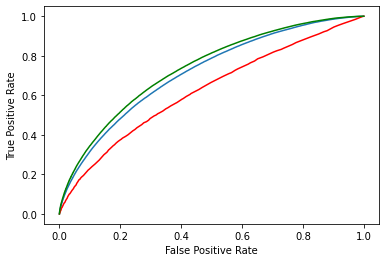

In [1258]:
fpr, tpr, _ = metrics.roc_curve(
    df_pretendent["y"]
    ,  df_pretendent["predict"]
)

print("gini our model =", metrics.auc(fpr, tpr)*2 - 1)

fpr2, tpr2, _ = metrics.roc_curve(
    df_pretendent["y"]
    ,  df_pretendent["naive_predict"]
)

print("gini naive model =", metrics.auc(fpr2, tpr2)*2 - 1)

fpr3, tpr3, _ = metrics.roc_curve(
    df_pretendent["y"]
    ,  df_pretendent["predict_prop"]
)

print("best model =", metrics.auc(fpr3, tpr3)*2 - 1)
#create ROC curve
plt.plot(fpr,tpr)
plt.plot(fpr2,tpr2, "r")
plt.plot(fpr3,tpr3, "g")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [1259]:
df_pretendent.sort_values(by=["customer_num", "naive_predict"], ascending=False, inplace=True)

In [1260]:
df_pretendent["naive_rank"] = df_pretendent.groupby("customer_num")["article_num"].cumcount()+1

In [1261]:
df_pretendent.sort_values(by=["customer_num", "predict_prop"], ascending=False, inplace=True)

In [1262]:
df_pretendent["prop_rank"] = df_pretendent.groupby("customer_num")["article_num"].cumcount()+1

In [1263]:
df_pretendent.groupby("rank")["y", "predict"].mean().iloc[:12, :]

/var/folders/8q/pnrnrzxs48133m1ggwh8dlhc0000gp/T/ipykernel_34521/3662792287.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_pretendent.groupby("rank")["y", "predict"].mean().iloc[:12, :]


,y,predict
rank,,
1,0.013018,0.314378
2,0.012264,0.278718
3,0.010727,0.258043
4,0.009799,0.243079
5,0.008437,0.231003
6,0.008611,0.221047
7,0.007639,0.212202
8,0.007610,0.204744
9,0.007393,0.197752


In [1264]:
df_pretendent.groupby("article_num")["y", "predict"].mean().sort_values(by="y", ascending=False)

/var/folders/8q/pnrnrzxs48133m1ggwh8dlhc0000gp/T/ipykernel_34521/368622858.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_pretendent.groupby("article_num")["y", "predict"].mean().sort_values(by="y", ascending=False)


,y,predict
article_num,,
104553,0.011061,0.167610
104072,0.008248,0.174485
104554,0.007726,0.086574
104527,0.007437,0.027621
95499,0.006973,0.067096
...,...,...
100319,0.000290,0.017815
100801,0.000261,0.013660
79796,0.000261,0.032973


/var/folders/8q/pnrnrzxs48133m1ggwh8dlhc0000gp/T/ipykernel_34521/3110080104.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_pretendent.groupby("article_num")["y", "predict"].mean().sort_values(by="predict", ascending=False).plot.scatter(x="predict", y="y", s=1)


<AxesSubplot:xlabel='predict', ylabel='y'>

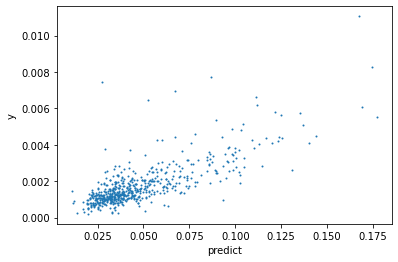

In [1265]:
df_pretendent.groupby("article_num")["y", "predict"].mean().sort_values(by="predict", ascending=False).plot.scatter(x="predict", y="y", s=1)

/var/folders/8q/pnrnrzxs48133m1ggwh8dlhc0000gp/T/ipykernel_34521/1013666978.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_pretendent.groupby("article_num")["y", "predict_prop"].mean().sort_values(by="predict_prop", ascending=False).plot.scatter(x="predict_prop", y="y", s=1)


<AxesSubplot:xlabel='predict_prop', ylabel='y'>

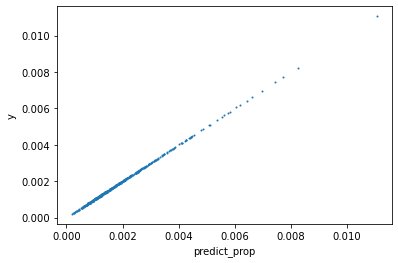

In [1266]:
df_pretendent.groupby("article_num")["y", "predict_prop"].mean().sort_values(by="predict_prop", ascending=False).plot.scatter(x="predict_prop", y="y", s=1)

In [1267]:
df_pretendent["g200_predict"] = articles_g200_probabilities[current_week][df_pretendent["article_num"]]

/var/folders/8q/pnrnrzxs48133m1ggwh8dlhc0000gp/T/ipykernel_34521/207241107.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_pretendent.groupby("article_num")["y", "g200_predict"].mean().plot.scatter(x="g200_predict", y="y", s=1)


<AxesSubplot:xlabel='g200_predict', ylabel='y'>

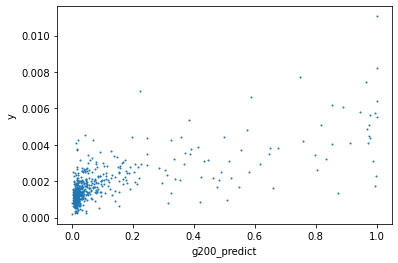

In [1268]:
df_pretendent.groupby("article_num")["y", "g200_predict"].mean().plot.scatter(x="g200_predict", y="y", s=1)

In [1269]:
df_pretendent.groupby("article_num")["y", "predict"].mean().sort_values(by="predict", ascending=False)

/var/folders/8q/pnrnrzxs48133m1ggwh8dlhc0000gp/T/ipykernel_34521/4235189654.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_pretendent.groupby("article_num")["y", "predict"].mean().sort_values(by="predict", ascending=False)


,y,predict
article_num,,
95217,0.005538,0.176896
104072,0.008248,0.174485
67522,0.006059,0.169080
104553,0.011061,0.167610
104073,0.004494,0.144092
...,...,...
101373,0.000464,0.017080
100801,0.000261,0.013660
58588,0.000913,0.012459


In [1270]:
transactions_train[transactions_train["article_num"] == 103108].groupby("t_weekn")["customer_num"].nunique()

t_weekn
102      42
103    1052
104     444
Name: customer_num, dtype: int64

In [1271]:
map_at_k(
    df_pretendent[df_pretendent["prop_rank"]<=12],
    transactions_train[transactions_train["t_weekn"]==n_weeks],
    rank_column="rank"
)

0.010232404414751088

In [1272]:
map_at_k(
    df_pretendent[df_pretendent["rank"]<=12],
    transactions_train[transactions_train["t_weekn"]==n_weeks],
    rank_column="rank"
)

0.011531160622979127

In [1273]:
map_at_k(
    df_pretendent[df_pretendent["naive_rank"]<=12],
    transactions_train[transactions_train["t_weekn"]==current_week],
    rank_column="naive_rank"
)

0.00813898760052937

In [1274]:
del df_pretendent, df_for_prop, df_pretendents

#### Итоговое предсказание для n_weeks+1

In [ ]:
current_week = n_weeks + 1
articles_for_test = np.array([i for i, x in enumerate(articles_g50_probabilities[current_week] > 0.5) if x])
customers_for_test = df_customers_ids.copy()

In [ ]:
current_time = time.time()

df_pretendent = construct_df_pretendent_quick_v2(current_week=current_week,
                                                 customers_for_test=customers_for_test["customer_num"],
                                                 articles_for_test=articles_for_test,
                                                 construct_dataset_fun=construct_dataset_v7, model=model)

print(time.time() - current_time)
df_pretendent2 = pd.concat(df_pretendent, axis=0, ignore_index=True)
df_pretendent2 = df_pretendent2[["customer_num", "article_num", "rank"]]
df_pretendent2 = pd.merge(
    pd.merge(df_pretendent2, df_customers_ids, on="customer_num"),
    df_articles_ids, on="article_num"
)
df_pretendent2.sort_values(by=["customer_num", "rank"], inplace=True)
df_pretendent2["article_id"] = df_pretendent2["article_id"].astype(str)
result = df_pretendent2.groupby("customer_id")["article_id"].apply(' '.join).reset_index()
result.rename(columns={"article_id": "prediction"}, inplace=True)
result.to_csv("submission001.csv", index=False)

# Архив

#### transfer learning

In [ ]:
mymap = {
    "dense_article_l0": "dense_20",
    "dense_purchase_history_l0": "dense_22",
    "dense_customer_l0": "dense_19",
    "dense_article_l1": "dense_21",
    "dense_purchase_history_l1": "dense_23",
    "dense_t2": "dense_25",
    "dense_t1": "dense_26",
    "output_target_val": "output_target_val"
}

for key in mymap.keys():
    model.get_layer(key).set_weights(old_model.get_layer(mymap[key]).get_weights())

model.get_layer("dense_t3").set_weights(
    [np.concatenate(
        [old_model.get_layer("dense_24").get_weights()[0],
         model.get_layer("dense_t3").get_weights()[0][-8:,:]],
        axis=0
    ),
        old_model.get_layer("dense_24").get_weights()[1]]
)